* [1.Fonctions utilisateurs](#fc)
* [2.Description des données](#dd)
* [3.Clustering](#clus)
  * [3.1.Kmeans(RFM)](#kmeans1)
  * [3.2.Kmeans(RFM+review_score)](#kmeans2)
  * [3.3.DBSCAN(RFM)](#db)
  * [3.5.Mini batch kmeans (RFM)](#ag)
  * [3.5.Kprototypes(RFM+favorite_purshase_month)](#kp)
* [4.Récapitulation](#st)


In [36]:
#!pip install yellowbrick
#!pip install kmodes

#!pip install autopep8
#!pip install jupyter_contrib_nbextensions

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import time
import os
import missingno as msno
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [38]:
os.getcwd()
#os.chdir('C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5')

'C:\\Users\\imen2\\OneDrive\\Documents\\Openclassrooms\\formation_OC\\projet5'

## 1. Fonctions utilisateurs <a class="anchor" id="fc"></a>

In [39]:
def felbow_kprototypes(k_rng, data, index_categ_feat):
    '''This function  aims at choosing the best nuber of clusters when using kprototypes based on the elbow method.
    Parameters:
    k_rng:range of tested number of clusters
    data:the dataframe
    index_categ_feat:index of categorical feature using with the kproptypes clustering

    '''
    cost = []
    for i in k_rng:
        print(i)
        print('{cluster}\.cluster start'.format(cluster=i))
        kproto = KPrototypes(n_clusters=i, init='Huang',
                             n_jobs=-1, n_init=10, verbose=1)
        kproto.fit(data, categorical=[index_categ_feat])
        cost.append(kproto.cost_)

    plt.plot(k_rng, cost)
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

In [40]:
def mean_clus_feat(df, group, feat):
    '''
    This function gives the mean of a feature in a group
    df: a dataframe
    group: the column by which the grouping is made
    feat: the variable for which we calculate the mean
    '''
    df_mean = pd.DataFrame(df.groupby(group)[feat].mean()).rename(
        columns={feat: feat+'_mean'})
    return df_mean

In [41]:
def fnb_customper_cluster(df):
    '''
    this function gives the number of customers by cluster
    Parameters:
    df: the dataframe where each customer designed by its CustomerID is assigned for cluster given by ClusterID
    '''
    customer_per_cluster = pd.DataFrame(df.groupby('ClusterID')['CustomerID'].count())\
        .rename(columns={'CustomerID': 'nb_customers'}).reset_index()
    return (customer_per_cluster)

In [42]:
def fpairplot(df, lists, title):
    '''
    This function aims at scatter plot of all feature pairs given in the lists.
    Parameters:
    df: the dataframe
    lists: a list of pair of feature(in df)
    title: a figure title
    '''
    fig = plt.figure(constrained_layout=True, figsize=(20, 5))

    gs = GridSpec(1, len(lists), figure=fig)
    #"Recency", "Frequency", "Monetary"
    #lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
    i = 0
    for c in lists:
        plt.subplot(gs[0, i])
        sns.scatterplot(data=df, x=c[0], y=c[1]).set(title=title)
        i = i+1

In [43]:
def fkelbowvis(model, ks, X):
    '''
    This function aims at looking for the best k of the clustering model based on the elbow method.
    Parameters:
    model:the clustering model.
    ks: the studied range  of number of clusters
    X:is the dat on which the model will be fitted
    '''
    visualizer = KElbowVisualizer(model, k=ks)
    visualizer.fit(X)    # Fit the data to the visualizer
    visualizer.poof()

In [44]:
def fsilhouettevis(model, X):
    '''
    This function aims at validating the number of cluster passed when creating the model based on the silhouette score.
    Parameters:
    model:the clustering model.   
    X:is the data on which the model will be fitted
    '''
    visualizer2 = SilhouetteVisualizer(model)
    visualizer2.fit(X)    # Fit the data to the visualizer
    visualizer2.poof()

## 2.Description des données<a class="anchor" id="dd"></a>

In [5]:
#df_cmd = pd.read_csv('commandes_dataset.csv')
#df_geo = pd.read_csv('geolocalisation_dataset.csv')
# RFM=pd.read_csv('df_rfm.csv')
#RFM_date = pd.read_csv('df_rfm_date.csv')
RFM_score_review = pd.read_csv('df_rfm_date_score.csv')

In [46]:
RFM_date.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date', 'favorite_purshase_month'],
      dtype='object')

In [3]:
RFM = RFM_score_review[['customer_unique_id',
                        'Frequency', 'Recency', 'Monetary']]
RFM

customer_unique_id  Frequency  Recency  Monetary
0      0000366f3b9a7992bf8c76cfdf3221e2          1      112    129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      115     18.90
2      0000f46a3911fa3c0805444483337064          1      537     69.00
3      0000f6ccb0745a6a4b88665a16c9f078          1      321     25.99
4      0004aac84e0df4da2b147fca70cf8255          1      288    180.00
...                                 ...        ...      ...       ...
91473  fffcf5a5ff07b0908bd4e2dbc735a684          2      447   1570.00
91474  fffea47cd6d3cc0a88bd621562a9d061          1      262     64.89
91475  ffff371b4d645b6ecea244b27531430a          1      568     89.90
91476  ffff5962728ec6157033ef9805bacc48          1      119    115.00
91477  ffffd2657e2aad2907e67c3e9daecbeb          1      484     56.99

[91478 rows x 4 columns]

In [49]:
RFM.isna().sum()

customer_unique_id    0
Frequency             0
Recency               0
Monetary              0
dtype: int64

## 3.Clustering <a class="anchor" id="clus"></a>

### 3.1.Kmeans (RFM)<a class="anchor" id="kmeans1"></a>

In [51]:
X = RFM[['Frequency', 'Recency', 'Monetary']]
# Scaling input using StandardScaler

scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [52]:
Xstd.describe()

Frequency       Recency      Monetary
count  9.147800e+04  9.147800e+04  9.147800e+04
mean   9.439287e-17 -2.268070e-17 -1.222583e-16
std    1.000005e+00  1.000005e+00  1.000005e+00
min   -3.115796e-01 -1.547248e+00 -6.520442e-01
25%   -3.115796e-01 -8.065545e-01 -4.346193e-01
50%   -3.115796e-01 -1.248539e-01 -2.490954e-01
75%   -3.115796e-01  7.076075e-01  6.358022e-02
max    3.353783e+01  3.001792e+00  6.015974e+01

In [53]:
k_rng = range(2, 11)

#### Choix de k

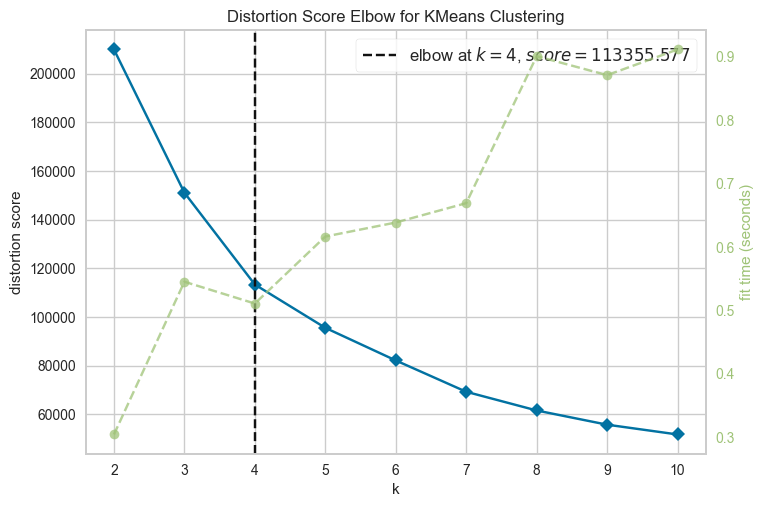

In [54]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
fkelbowvis(model, k_rng, Xstd)

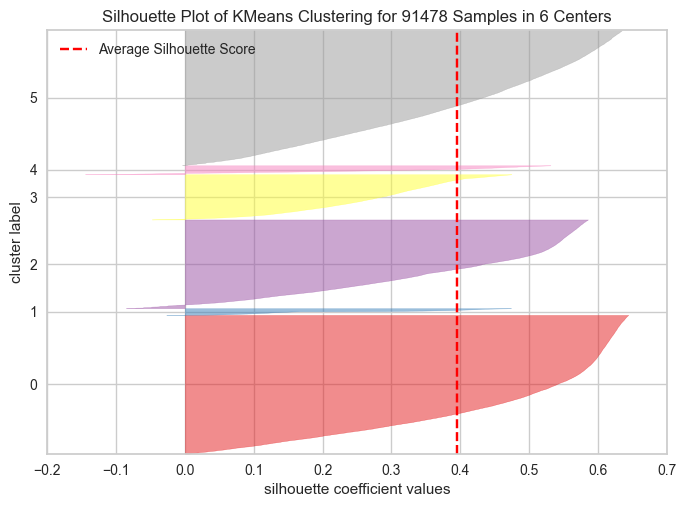

In [55]:
fsilhouettevis(KMeans(6, random_state=42), Xstd)

**Remarque**<br>
-le silhouette score est entre - et 1<br>
-score proche de 1==>les points du meme cluster sont très similaire<br>
-score proche de -1==>les points du meme cluster ne sont très similaire


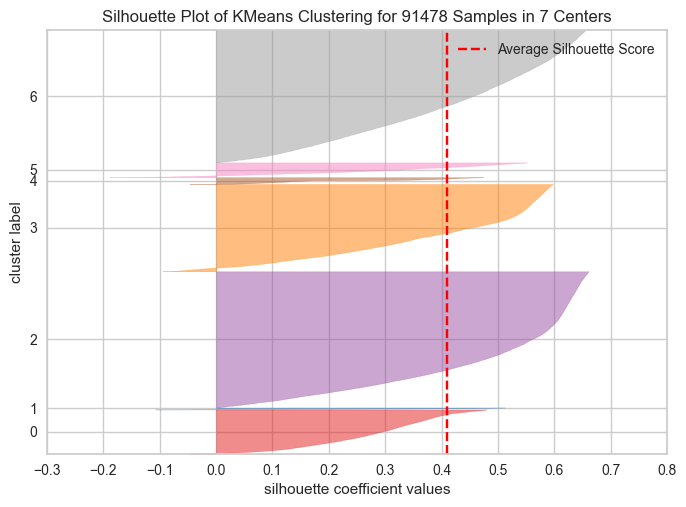

In [56]:
fsilhouettevis(KMeans(7, random_state=42), Xstd)

In [57]:
silhouette_avg7 = silhouette_score(
    Xstd, KMeans(7, random_state=42).fit_predict(Xstd))
print(f'pour 7  clusters, le silhouette score est égal {silhouette_avg7}')

pour 7  clusters, le silhouette score est égal 0.4098896855054131


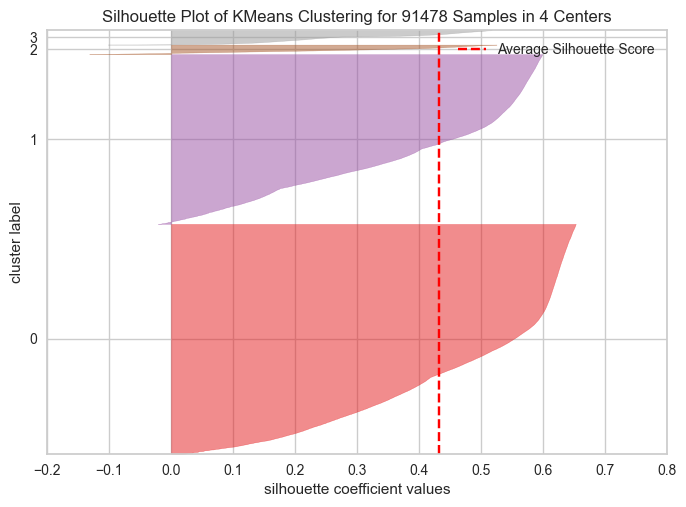

In [58]:
fsilhouettevis(KMeans(4, random_state=42), Xstd)

**Observations**<br>
Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.
<br>
les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

In [59]:
selected_k1 = 4

In [60]:
# pour k=4
start_kmeansRFM = time.time()
kmeans = KMeans(n_clusters=selected_k1, init="k-means++", random_state=42)
elapsed_time_kmeansRFM = time.time()-start_kmeansRFM
print(f"Elpsed time kmeans RFM: {elapsed_time_kmeansRFM}")
y_kmeans = kmeans.fit_predict(Xstd)
y_kmeans

Elpsed time kmeans RFM: 0.0


array([0, 0, 1, ..., 1, 0, 1])

In [61]:
elapsed_time_kmeansRFM2 = format(float(elapsed_time_kmeansRFM), ".50f")
elapsed_time_kmeansRFM2

'0.00000000000000000000000000000000000000000000000000'

In [62]:
silhouette_avg = silhouette_score(Xstd, y_kmeans)
print(
    "Kmeans RFM  average silhouette_score is :",
    silhouette_avg,
)

Kmeans RFM  average silhouette_score is : 0.43179645876872036


For n_clusters = 4 The average silhouette_score is : 0.43179645876872036

#### Analyse des clusters

In [63]:
k_selected = 4

In [13]:
def add_cluster_data(data, y, cols):
    '''
    this functions aims at adding the nuber of cluster column to the dataframe
    Parameters:
    data:dataframe
    y:list of the labels
    cols:list of the feature name
    '''
    data_label = pd.concat([data, pd.Series(y)], axis=1)
    data_label.columns = cols
    data_label.head()
    return (data_label)

In [68]:
RFM_km = add_cluster_data(RFM, y_kmeans, ['CustomerID', 'Frequency',
                                          'Recency', 'Monetary', 'ClusterID'])
RFM_km

CustomerID  Frequency  Recency  Monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      112    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      115     18.90   
2      0000f46a3911fa3c0805444483337064          1      537     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1      321     25.99   
4      0004aac84e0df4da2b147fca70cf8255          1      288    180.00   
...                                 ...        ...      ...       ...   
91473  fffcf5a5ff07b0908bd4e2dbc735a684          2      447   1570.00   
91474  fffea47cd6d3cc0a88bd621562a9d061          1      262     64.89   
91475  ffff371b4d645b6ecea244b27531430a          1      568     89.90   
91476  ffff5962728ec6157033ef9805bacc48          1      119    115.00   
91477  ffffd2657e2aad2907e67c3e9daecbeb          1      484     56.99   

       ClusterID  
0              0  
1              0  
2              1  
3              1  
4              1  
...          ...  
91473          2  
91474          1  
91475          1  
91476          0  
91477          1  

[91478 rows x 5 columns]

In [66]:
customer_per_cluster1 = fnb_customper_cluster(RFM_km)
customer_per_cluster1

ClusterID  nb_customers
0          0         49657
1          1         36679
2          2          2053
3          3          3089

**Obserrvations**<br>
le cluster 1 contient le plus de clients
    

In [69]:
cluster0 = RFM_km[RFM_km.ClusterID == 0]
cluster1 = RFM_km[RFM_km.ClusterID == 1]
cluster2 = RFM_km[RFM_km.ClusterID == 2]
cluster3 = RFM_km[RFM_km.ClusterID == 3]

In [70]:
def boxplot_per_cluster(cluster, cols, til):
    '''
    this function aims at giving the boxplot of cols in the dataframe cluster
    parameters:
    cluster: dataframe for one cluster
    cols:lists of feature
    type_clustering: string used forn the title

    '''
    boxplot_cluster = cluster.boxplot(
        column=cols, color='blue', patch_artist=True)

    plt.title(til)
    plt.show

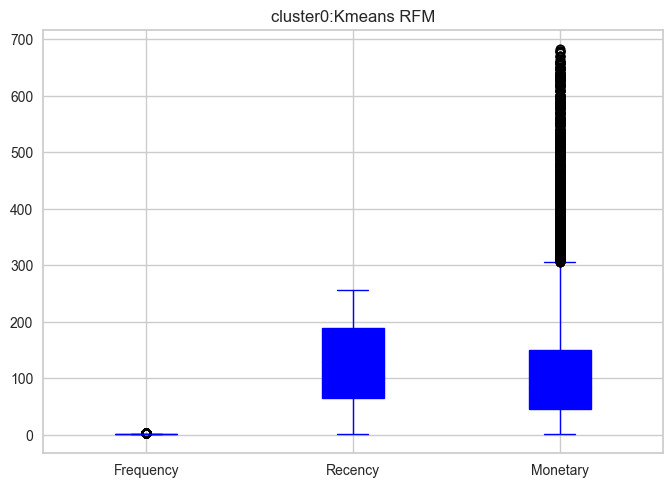

In [117]:
boxplot_per_cluster(
    cluster0, ['Frequency', 'Recency', 'Monetary'], 'cluster0:Kmeans RFM')

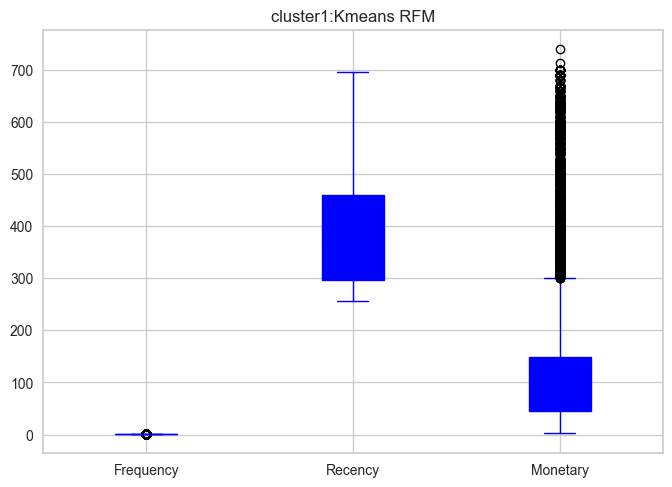

In [118]:
boxplot_per_cluster(
    cluster1, ['Frequency', 'Recency', 'Monetary'], 'cluster1:Kmeans RFM')

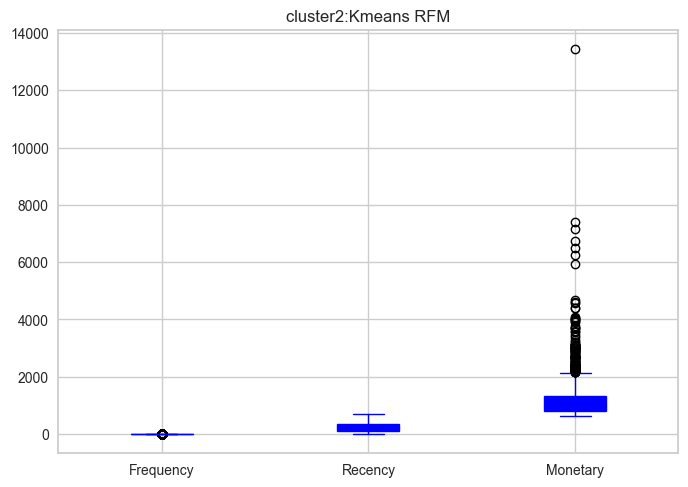

In [119]:
boxplot_per_cluster(
    cluster2, ['Frequency', 'Recency', 'Monetary'], 'cluster2:Kmeans RFM')

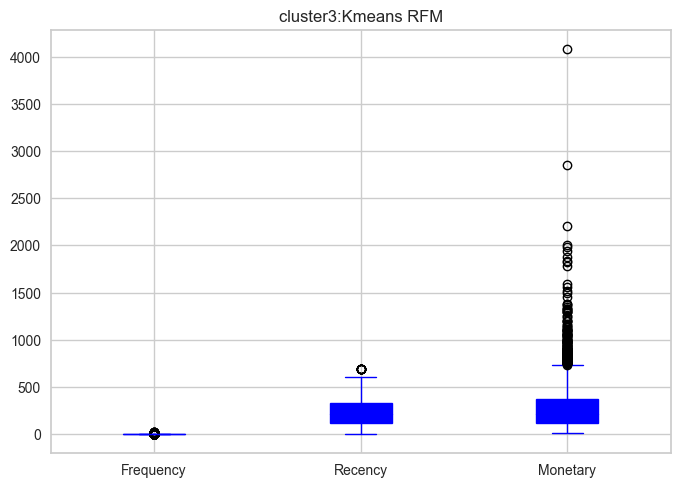

In [120]:
boxplot_per_cluster(
    cluster3, ['Frequency', 'Recency', 'Monetary'], 'cluster3:Kmeans RFM')

**Observations**<br>
Cluster0:Clients récents qui ont achtés peu de fois avec des montants faibles

**Observations**<br>
cluster1: clients anciens qui ont commandés peu de fois avec des montants faibles .

**Observations**<br>
cluster2: Clients récents qui ont commandés peu de fois avec des montants faibles (inférieur aux mantants du cluster0).

**Observations**<br>
cluster3: clients récents achetant peu de fois avec des montants faibles.

In [72]:
def boxplot_per_feature(data, col):
    '''
    this function aims at giving the boxplot of a feature for all clusters.
    parameters:
    cluster: dataframe for all clusters
    cols:string:feature name


    '''
    data.boxplot(column=col, by='ClusterID', color='red', patch_artist=True)

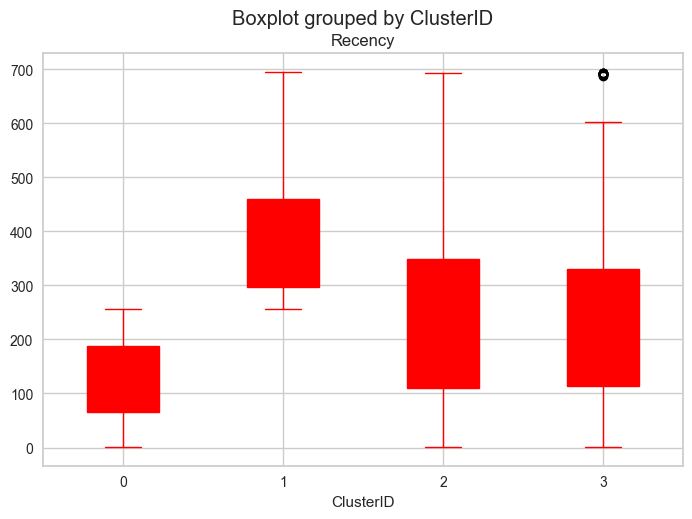

In [129]:
boxplot_per_feature(RFM_km, 'Recency')

**Observations**<br>
Pour la récence, que le cluster 0 contient des outliers.<br>
cluster0:client les plus récents<br>
cluster1:clients les moins récents.ça fait longtemps qu'ils ont commandés.

**Observations**<br>
Pour les montants,le troisieme cluster(2) ont les montants les plus élevés. 

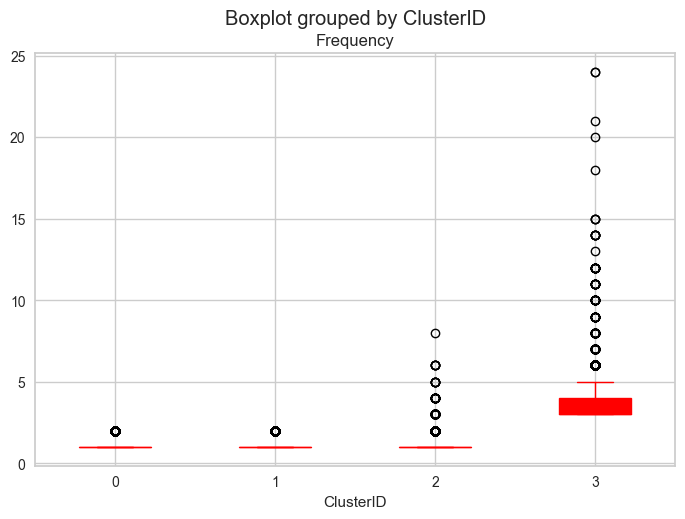

In [131]:
boxplot_per_feature(RFM_km, 'Frequency')

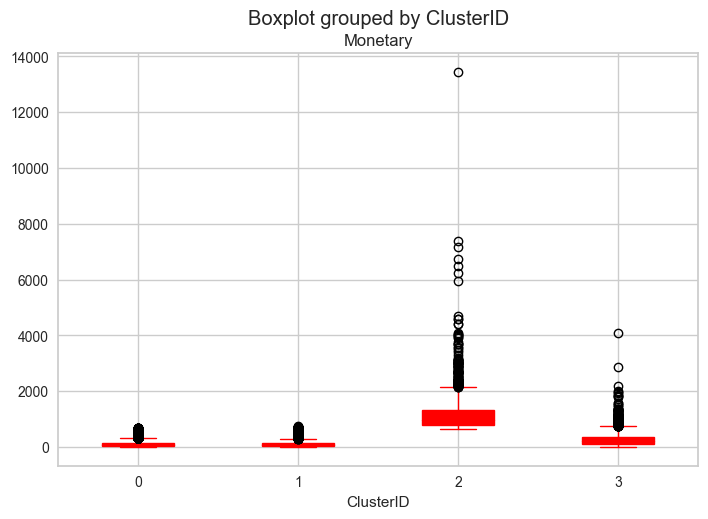

In [73]:
boxplot_per_feature(RFM_km, 'Monetary')

**Observations**<br>
-le cluster 0 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster 1 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster 2 contient que les clienst qui ont achétes peu de fois (1, 2, 3, 6, 8, 4, 5)<br>
-le cluster 3 contient que les clienst qui ont achétes entre 4 et 24 fois <br>

In [57]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]

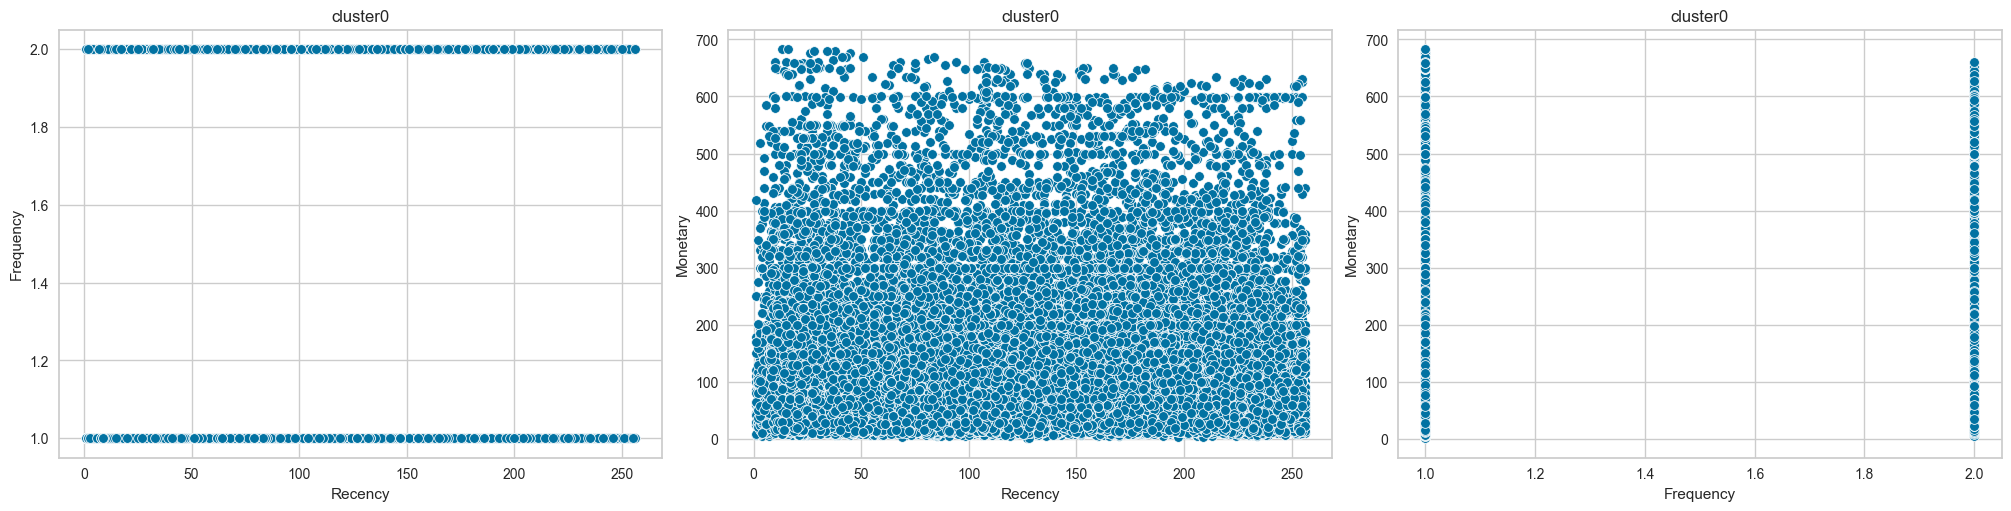

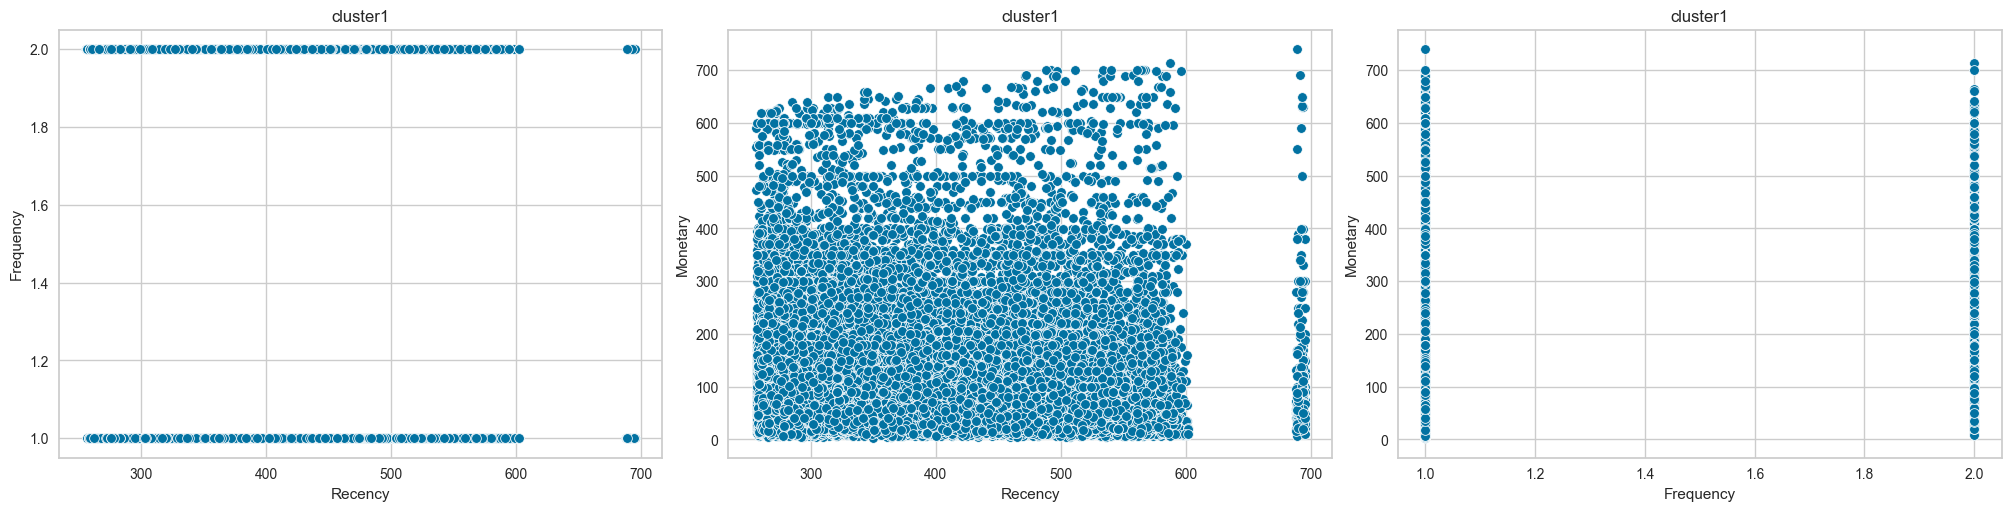

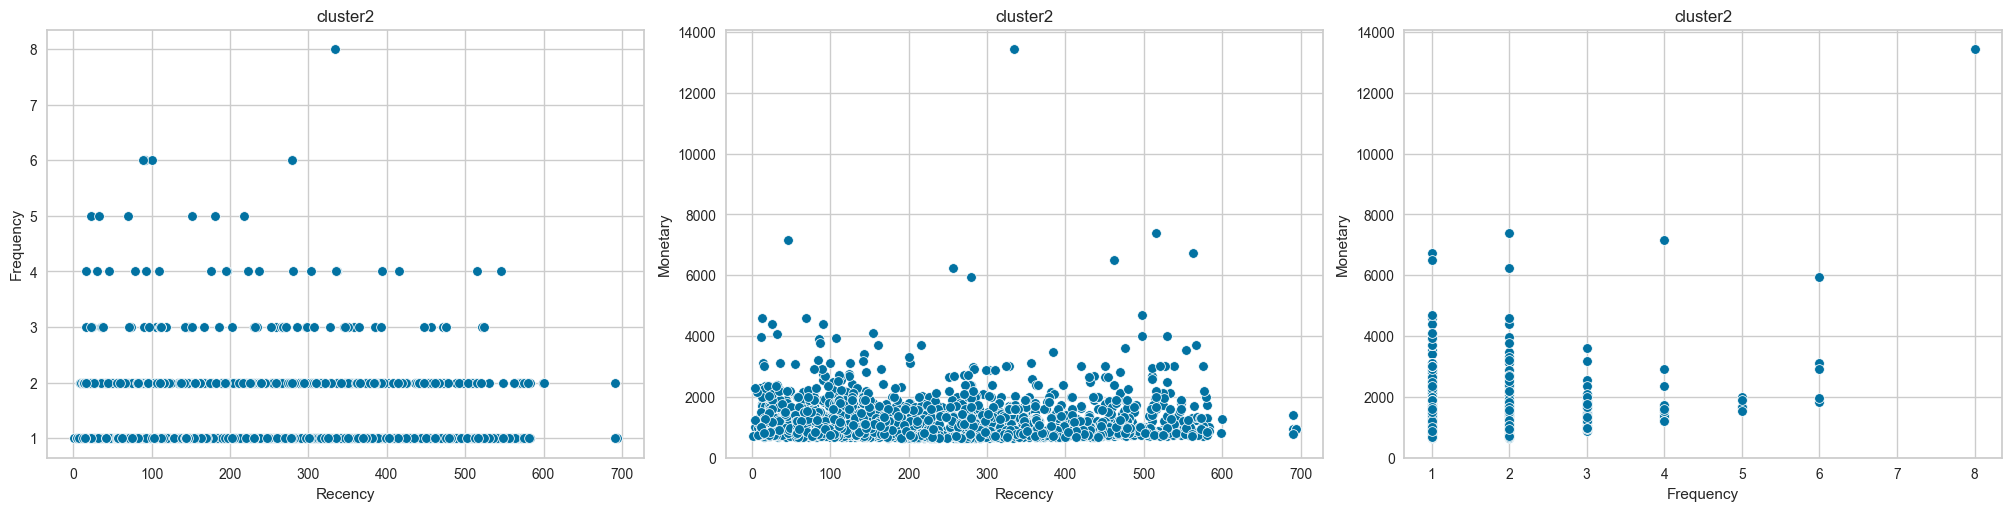

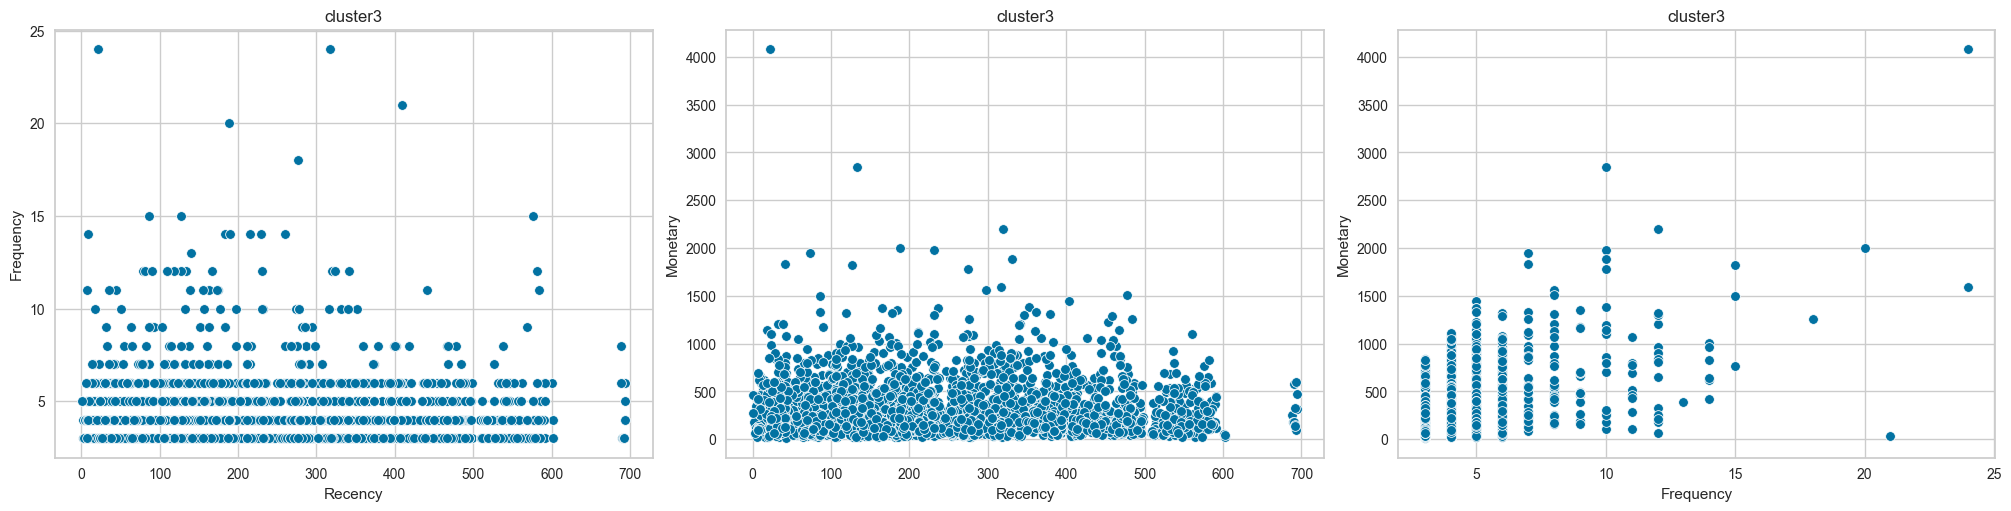

In [92]:
fpairplot(cluster0, lists, 'cluster0')
plt.show()
fpairplot(cluster1, lists, 'cluster1')
plt.show()
fpairplot(cluster2, lists, 'cluster2')
plt.show()
fpairplot(cluster3, lists, 'cluster3')

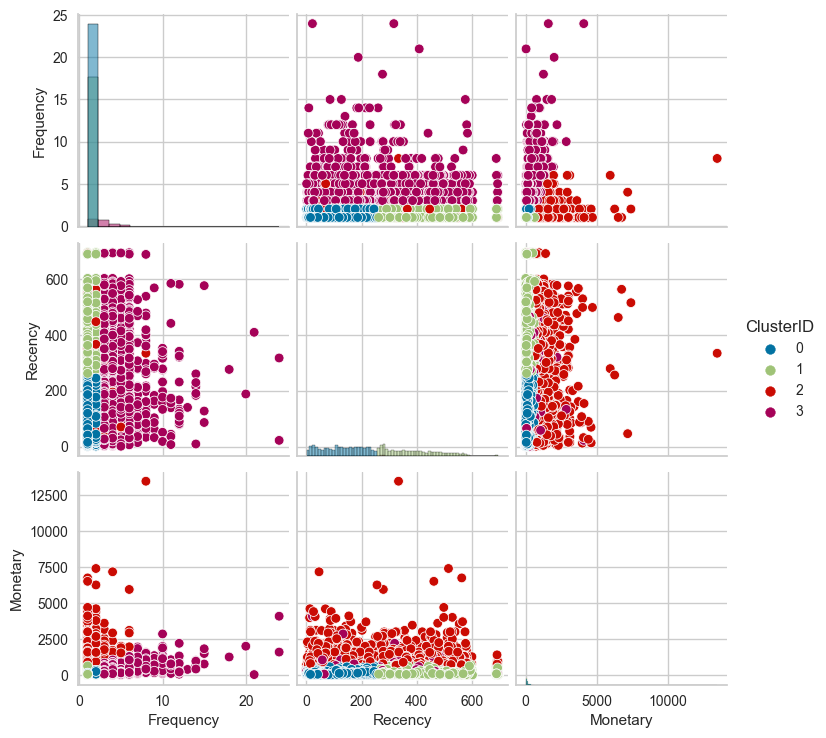

In [86]:
data = RFM_km[['ClusterID', 'Frequency',  'Recency', 'Monetary']]
sns.pairplot(data, hue='ClusterID', diag_kind="hist",
             palette=sns.color_palette(n_colors=4))

**Observations**<br>

In [87]:
km_recency_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Recency')
km_frequency_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Frequency')
km_monetary_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Monetary')

In [88]:
df = pd.concat([pd.Series([0, 1, 2, 3]), km_recency_clusters,
               km_frequency_clusters, km_monetary_clusters], axis=1)
df.columns = ["ClusterID", "Recency_mean", "Frequency_mean", "Monetary_mean"]

In [42]:
df

ClusterID  Recency_mean  Frequency_mean  Monetary_mean
0          0    126.984071        1.111263     114.837330
1          1    386.399029        1.113525     115.746640
2          2    236.316610        1.263030    1178.096069
3          3    233.444480        3.958239     289.112522

**Observations**<br>
-La moyenne de la récence du troisieme cluster est le plus proche de la moyenne de la récence globale(237à peu près). <br>



<AxesSubplot: xlabel='ClusterID', ylabel='Recency_mean'>

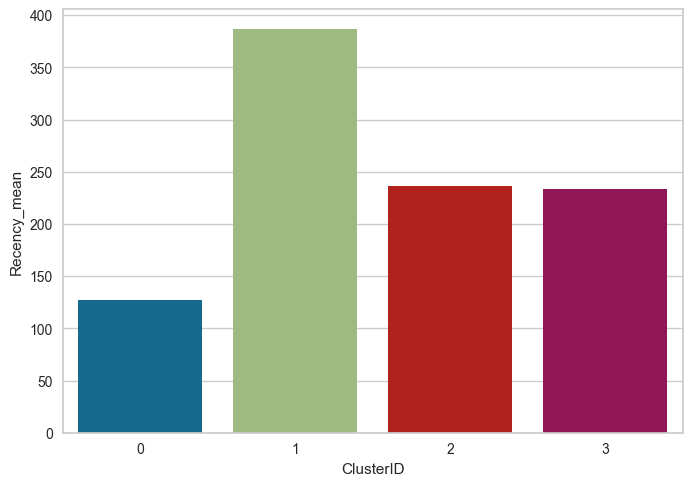

In [43]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

**Observations**<br>
Les clients du cluster(cluster0) sont les clients qui ont les commandes les plus récentes<br>
Les clients du cluster(cluster1) sont les clients qui ont les commandes les plus anciennes

<AxesSubplot: xlabel='ClusterID', ylabel='Frequency_mean'>

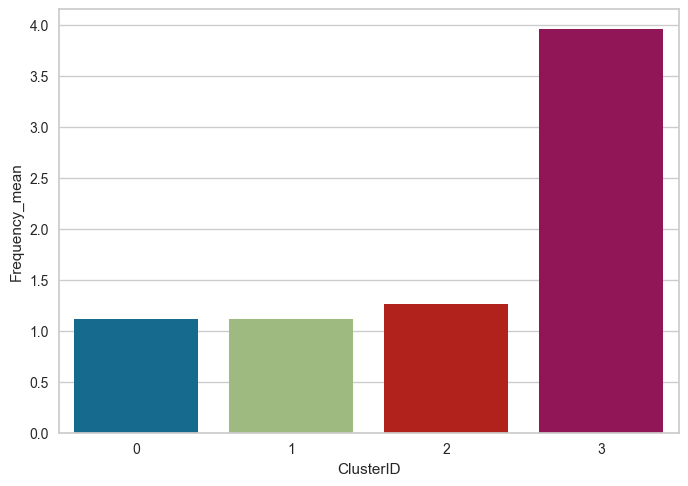

In [44]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

**Observations**<br>
Les clients du cluster 4 (cluster3) sont les clients qui ont effectuées plusieurs commandes

<AxesSubplot: xlabel='ClusterID', ylabel='Monetary_mean'>

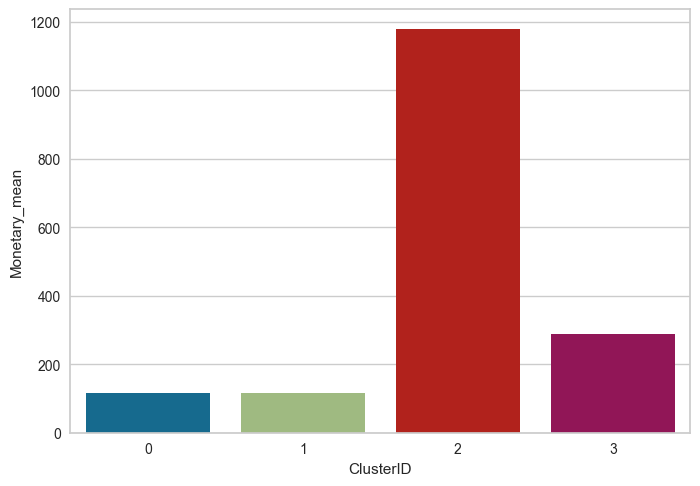

In [45]:
sns.barplot(x=df.ClusterID, y=df.Monetary_mean)

**Observations**<br>
Les clients du 3ème cluster(cluster 2) sont les clients qui ont payés le plus.
<br>


**Conclusion**<br>
.le 1er cluster(cluster 0):clients avec des montants faibles,fréquences faibles et récence faible<br>
.le 2ème cluster(cluster 1):clients avec des commandes récentes<br>
.le 3ème cluster(cluster 2):clients avec des montants faibles.<br>
.le 4ème cluster(cluster 3): clients avec des montants élevés .<br>


#### Interprétation métier des clusters : Qualification des clients

In [80]:
customer_types = ['nouveau  client', ' client perdu',
                  'meilleur client', 'client risquant de partir']
rfm_caracte = ['client  avec faible fréquence et faibles dépenses et ça fait longtemps qu\'il n\'a pas passé de commandes',
               'client récent avec faible fréquence et dépenses',
               'client fréquent et plus au moins récent avec des dépenses importantes',
               'client avec faible  dépenses  et ça fait longtemps qu\'il n\'a pas passé de commandes'
               ]
d = {'Cluster': list(range(0, 4)), 'Type de client': customer_types,
     'Caractéristiques Kmeans RFM': rfm_caracte}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res1 = pd.DataFrame(d)

res1

Cluster       Type de client        \
0     0               nouveau  client   
1     1                  client perdu   
2     2               meilleur client   
3     3     client risquant de partir   

                                        Caractéristiques Kmeans RFM                                         
0  client  avec faible fréquence et faibles dépenses et ça fait longtemps qu'il n'a pas passé de commandes  
1                                                          client récent avec faible fréquence et dépenses  
2                                    client fréquent et plus au moins récent avec des dépenses importantes  
3                      client avec faible  dépenses  et ça fait longtemps qu'il n'a pas passé de commandes

### 3.2.Kmeans (RFM+review_score)<a class="anchor" id="kmeans2"></a>

In [5]:
RFM_score_review.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date', 'favorite_purshase_month', 'review_score_mean'],
      dtype='object')

In [4]:
RFM_score_review.shape

(91478, 7)

In [9]:
X1 = RFM_score_review[['Frequency', 'Recency',
                       'Monetary', 'review_score_mean']]
scaler = StandardScaler()
Xstd1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [94]:
k_rng = range(2, 11)

#### Choix de k

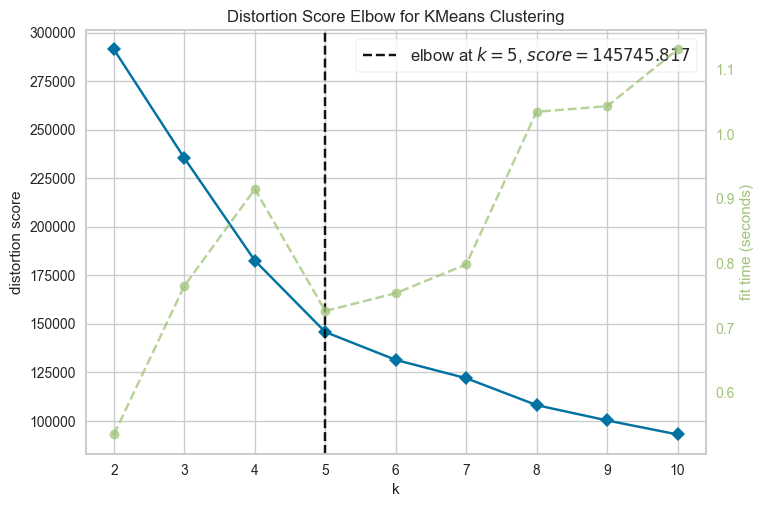

In [95]:
fkelbowvis(KMeans(init='k-means++', random_state=42), k_rng, Xstd1)

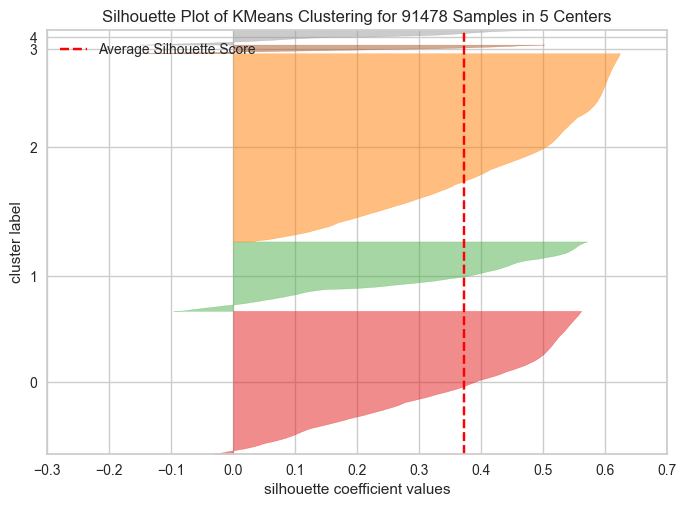

In [96]:
fsilhouettevis(KMeans(5, init='k-means++', random_state=42), Xstd1)

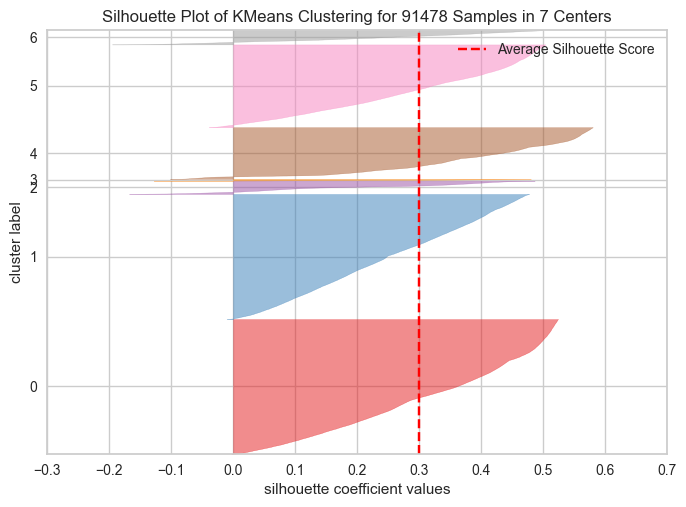

In [93]:
fsilhouettevis(KMeans(7, init='k-means++', random_state=42), Xstd1)

In [38]:
start_kmeans_RFM_score = time.time()
k_selected2 = 5
kmeans1 = KMeans(n_clusters=k_selected2, init="k-means++", random_state=42)
elapsed_time_kmeans_RFM_score = time.time()-start_kmeans_RFM_score
print(
    f"Elapsed time kmeans rfm+review_score{round(elapsed_time_kmeans_RFM_score,5)}")
y_kmeans1 = kmeans1.fit_predict(Xstd1)
y_kmeans1

Elapsed time kmeans rfm+review_score0.0


array([2, 2, 0, ..., 0, 2, 0])

In [264]:
elapsed_time_kmeans_RFM_score2 = format(
    float(elapsed_time_kmeans_RFM_score), ".50f")
elapsed_time_kmeans_RFM_score2

'0.00000000000000000000000000000000000000000000000000'

In [271]:
silhouette_avg1 = silhouette_score(Xstd1, y_kmeans1)
print("For n_clusters =",
      k_selected1,
      "kmeans rfm+review_score average silhouette_score is :",
      silhouette_avg1,
      )

For n_clusters = 5 kmeans rfm+review_score average silhouette_score is : 0.37248587628602475


#### Analyse des clusters

In [39]:
RFMS_km = pd.concat([RFM_score_review, pd.Series(y_kmeans1)], axis=1)
RFMS_km.columns = ['CustomerID', 'Frequency',  'Recency',
                   'Monetary', 'review_score_mean', 'ClusterID']

RFMS_km

CustomerID  Frequency  Recency  Monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      112    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      115     18.90   
2      0000f46a3911fa3c0805444483337064          1      537     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1      321     25.99   
4      0004aac84e0df4da2b147fca70cf8255          1      288    180.00   
...                                 ...        ...      ...       ...   
91473  fffcf5a5ff07b0908bd4e2dbc735a684          2      447   1570.00   
91474  fffea47cd6d3cc0a88bd621562a9d061          1      262     64.89   
91475  ffff371b4d645b6ecea244b27531430a          1      568     89.90   
91476  ffff5962728ec6157033ef9805bacc48          1      119    115.00   
91477  ffffd2657e2aad2907e67c3e9daecbeb          1      484     56.99   

       review_score_mean  ClusterID  
0                    5.0          2  
1                    4.0          2  
2                    3.0          0  
3                    4.0          0  
4                    5.0          0  
...                  ...        ...  
91473                5.0          3  
91474                4.0          0  
91475                5.0          0  
91476                5.0          2  
91477                5.0          0  

[91478 rows x 6 columns]

In [143]:
cust_per_clust = fnb_customper_cluster(RFMS_km)
cust_per_clust

ClusterID  nb_customers
0          0         30863
1          1         15002
2          2         40660
3          3          1863
4          4          3090

**Observations**<br>
le cluster 3 contient le moins de clients<br>
le cluster 2 contient le plus de clients

In [42]:
cluster0_rs = RFMS_km[RFMS_km.ClusterID == 0]
cluster1_rs = RFMS_km[RFMS_km.ClusterID == 1]
cluster2_rs = RFMS_km[RFMS_km.ClusterID == 2]
cluster3_rs = RFMS_km[RFMS_km.ClusterID == 3]
cluster4_rs = RFMS_km[RFMS_km.ClusterID == 4]

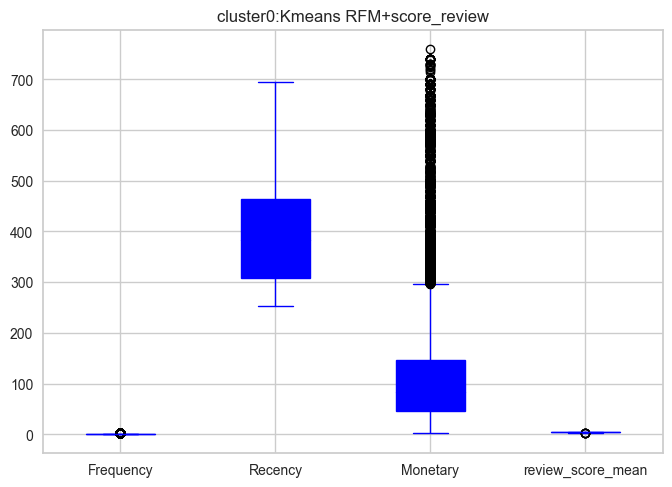

In [145]:
boxplot_per_cluster(cluster0_rs, ['Frequency', 'Recency', 'Monetary',
                    'review_score_mean'], 'cluster0:Kmeans RFM+score_review')

**Observations**<br>
Cluster0:clients récents avec des montants faibles,fréquences faibles et mécontents.

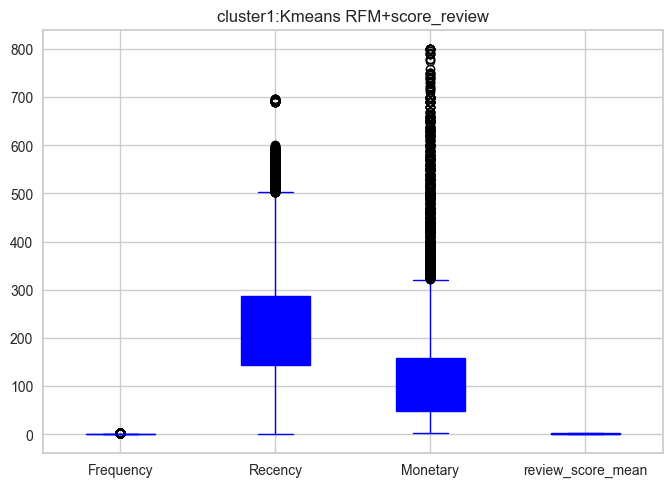

In [146]:
boxplot_per_cluster(cluster1_rs, ['Frequency', 'Recency', 'Monetary',
                    'review_score_mean'], 'cluster1:Kmeans RFM+score_review')

**Observations**<br>
Cluster1:clients mécontents


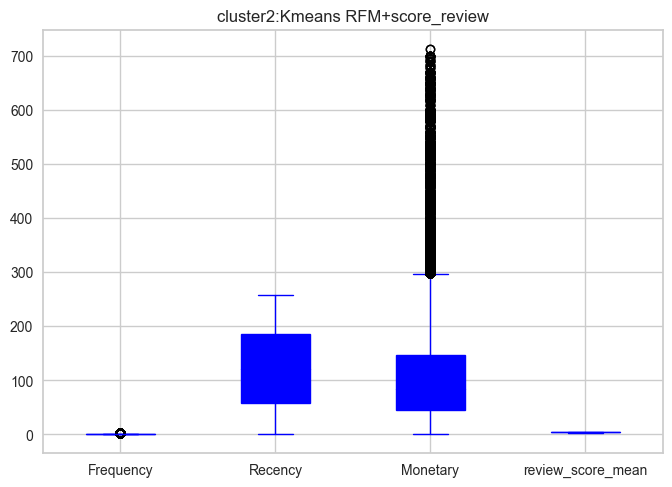

In [147]:
boxplot_per_cluster(cluster2_rs, ['Frequency', 'Recency', 'Monetary',
                    'review_score_mean'], 'cluster2:Kmeans RFM+score_review')

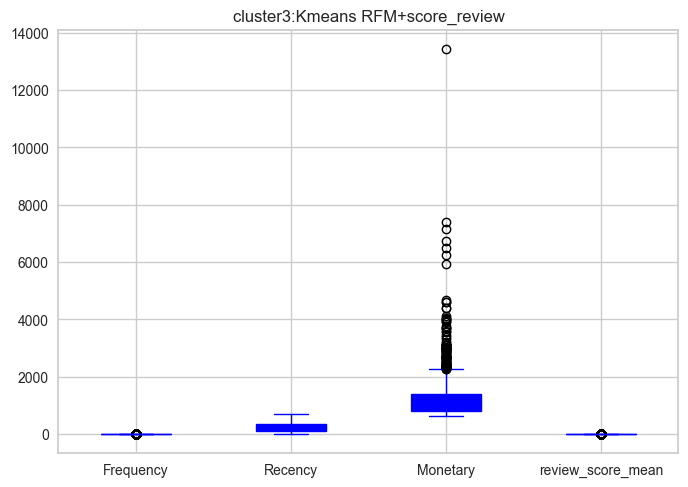

In [152]:
boxplot_per_cluster(cluster3_rs, ['Frequency', 'Recency', 'Monetary',
                    'review_score_mean'], 'cluster3:Kmeans RFM+score_review')

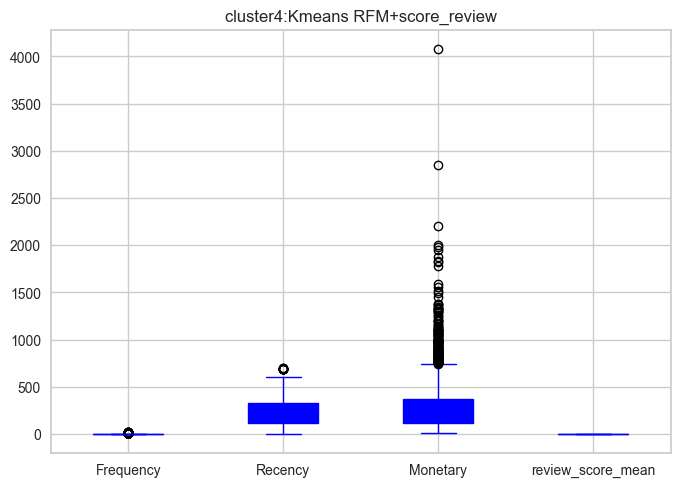

In [153]:
boxplot_per_cluster(cluster4_rs, ['Frequency', 'Recency', 'Monetary',
                    'review_score_mean'], 'cluster4:Kmeans RFM+score_review')

In [113]:
km1_recency_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Recency')
km1_frequency_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Frequency')
km1_monetary_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Monetary')
km1_score_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'review_score_mean')

In [114]:
df1 = pd.concat([pd.Series([0, 1, 2, 3, 4]), km1_recency_clusters,
                km1_frequency_clusters, km1_monetary_clusters, km1_score_clusters], axis=1)
df1.columns = ["ClusterID", "Recency_cluster",
               "Frequency_cluster", "Monetary_cluster", "scores_cluster"]
df1

ClusterID  Recency_cluster  Frequency_cluster  Monetary_cluster  \
0          0       392.591874           1.103166        116.014391   
1          1       229.701440           1.172244        124.686988   
2          2       122.124127           1.097418        113.781130   
3          3       234.043478           1.267311       1226.857654   
4          4       233.175405           3.957929        290.150544   

   scores_cluster  
0        4.641739  
1        1.760432  
2        4.705903  
3        4.162399  
4        3.654631

In [115]:
RFMS_km.describe()

Frequency       Recency      Monetary  review_score_mean  \
count  91478.000000  91478.000000  91478.000000       91478.000000   
mean       1.211712    237.047662    144.949038           4.154631   
std        0.679484    152.560470    220.997009           1.279228   
min        1.000000      1.000000      0.850000           1.000000   
25%        1.000000    114.000000     48.900000           4.000000   
50%        1.000000    218.000000     89.900000           5.000000   
75%        1.000000    345.000000    159.000000           5.000000   
max       24.000000    695.000000  13440.000000           5.000000   

          ClusterID  
count  91478.000000  
mean       1.249164  
std        1.051313  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        2.000000  
max        4.000000

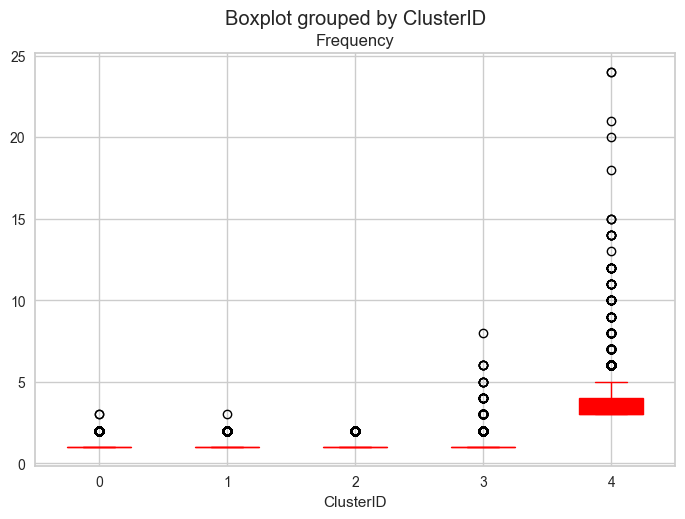

In [156]:
boxplot_per_feature(RFMS_km, 'Frequency')

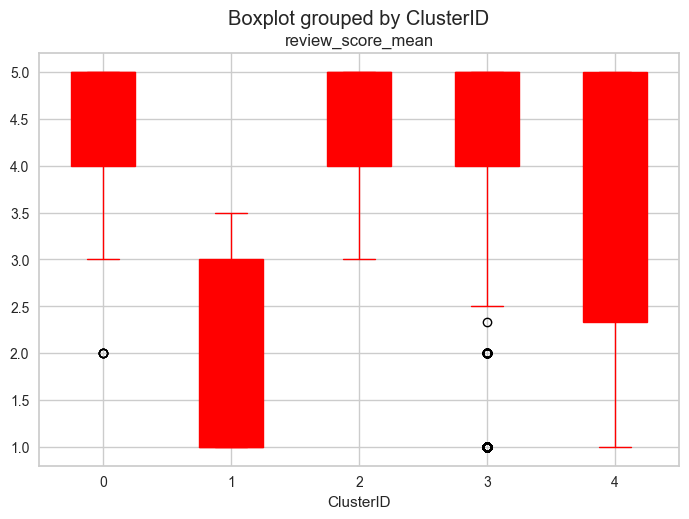

In [155]:
boxplot_per_feature(RFMS_km, 'review_score_mean')

**Observations**<br>
les clients du cluster 1 sont les plus mécontents
                    
                    
                    

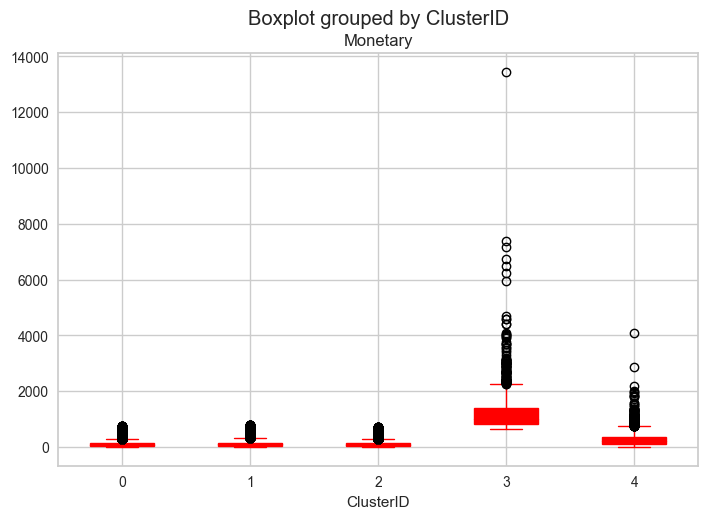

In [159]:
boxplot_per_feature(RFMS_km, 'Monetary')

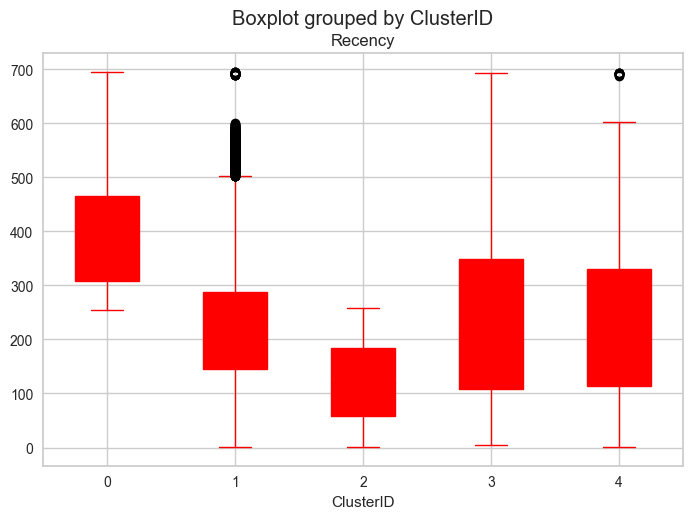

In [161]:
boxplot_per_feature(RFMS_km, 'Recency')

**Observations**<br>
les clients du cluster 2 sont les plus récents

In [53]:
lists1 = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"], ["Recency", "review_score_mean"], ["Frequency", "review_score_mean"], ["Monetary", "review_score_mean"]]

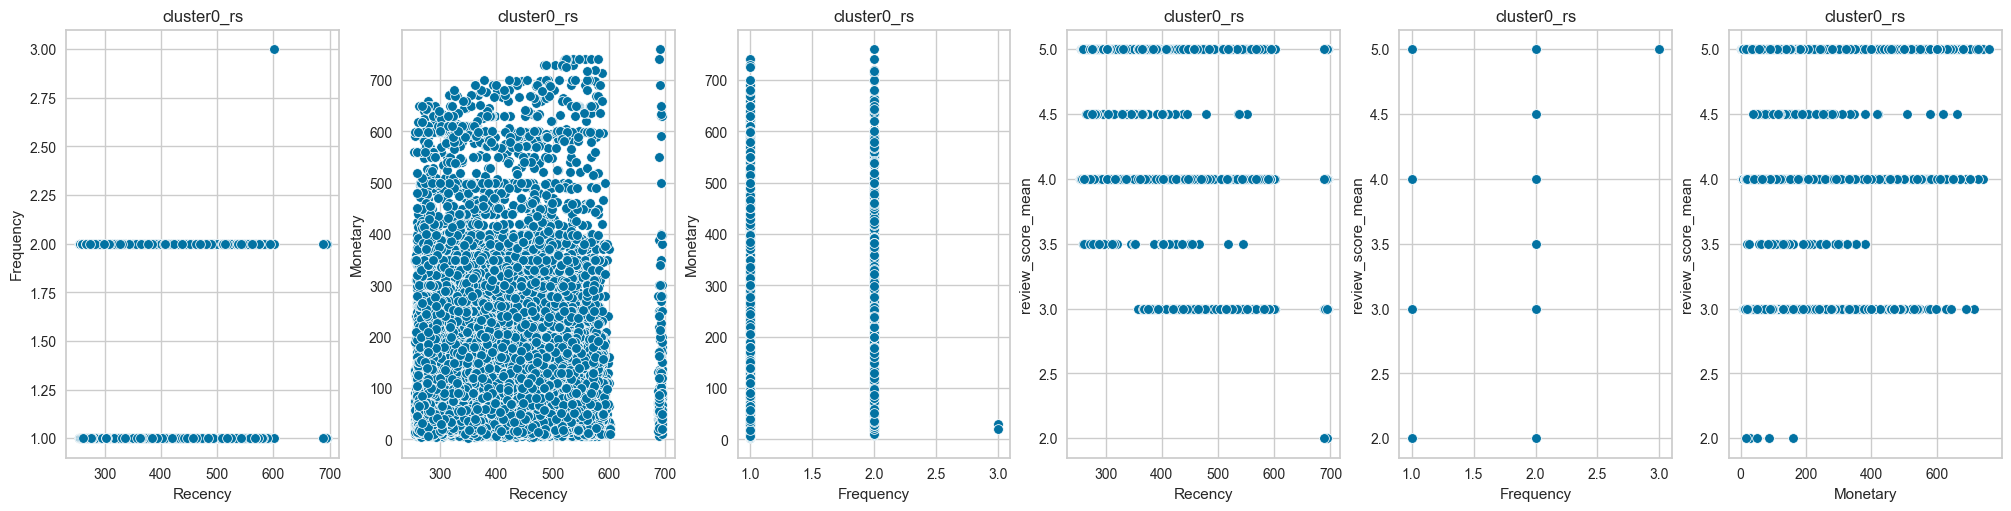

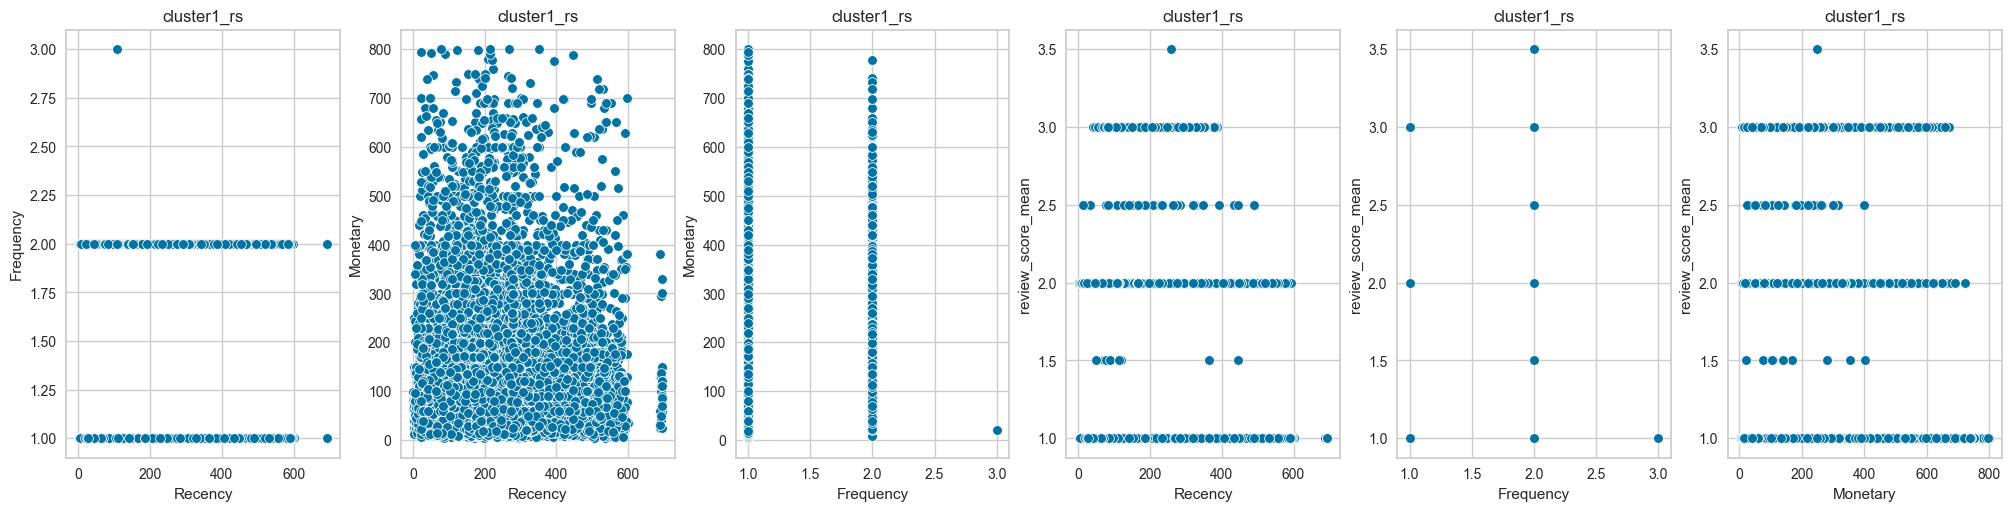

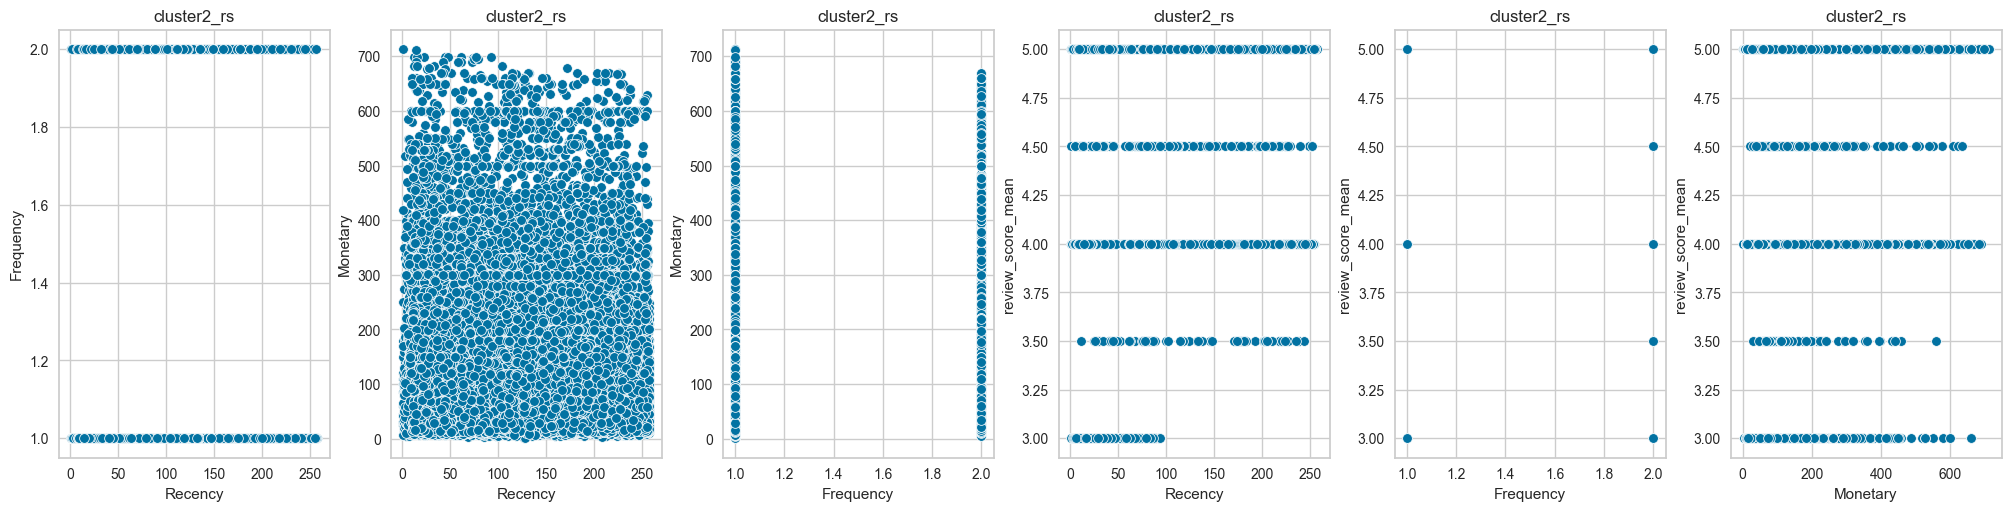

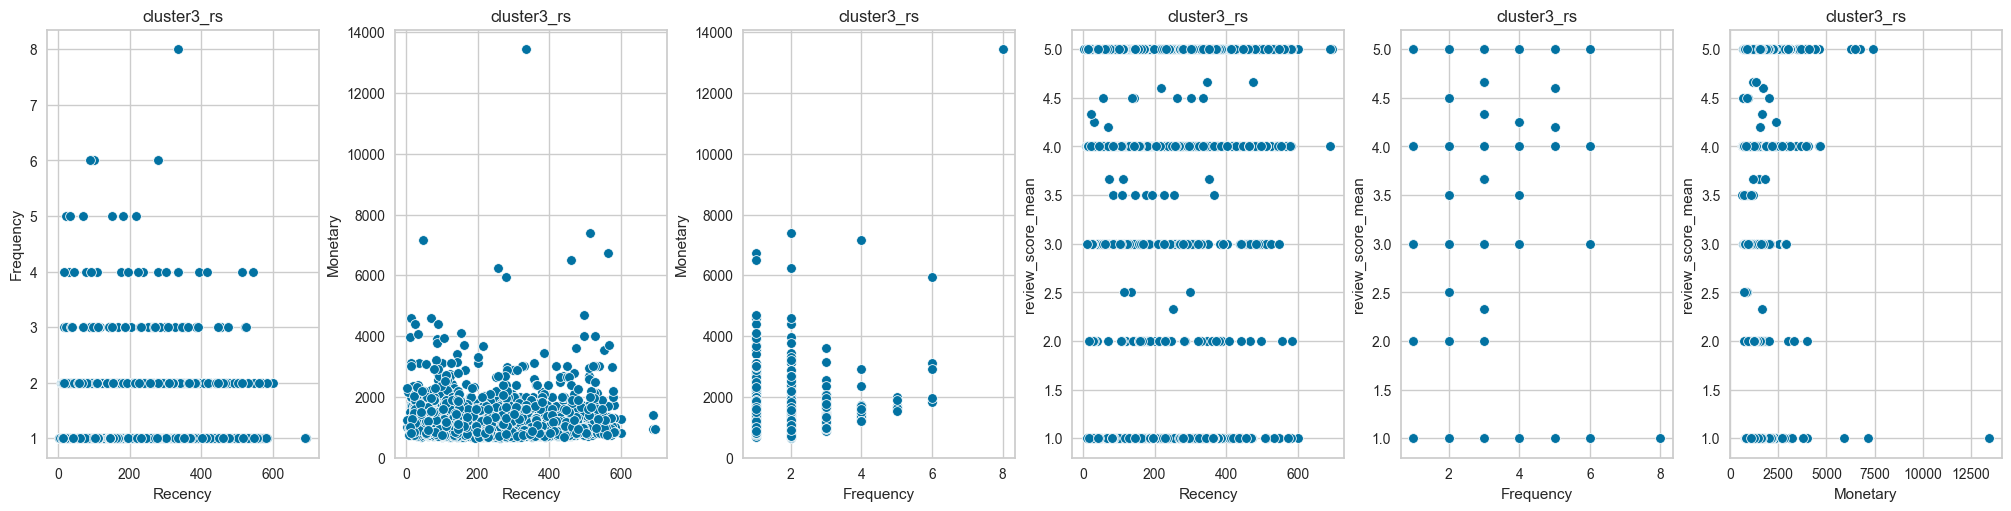

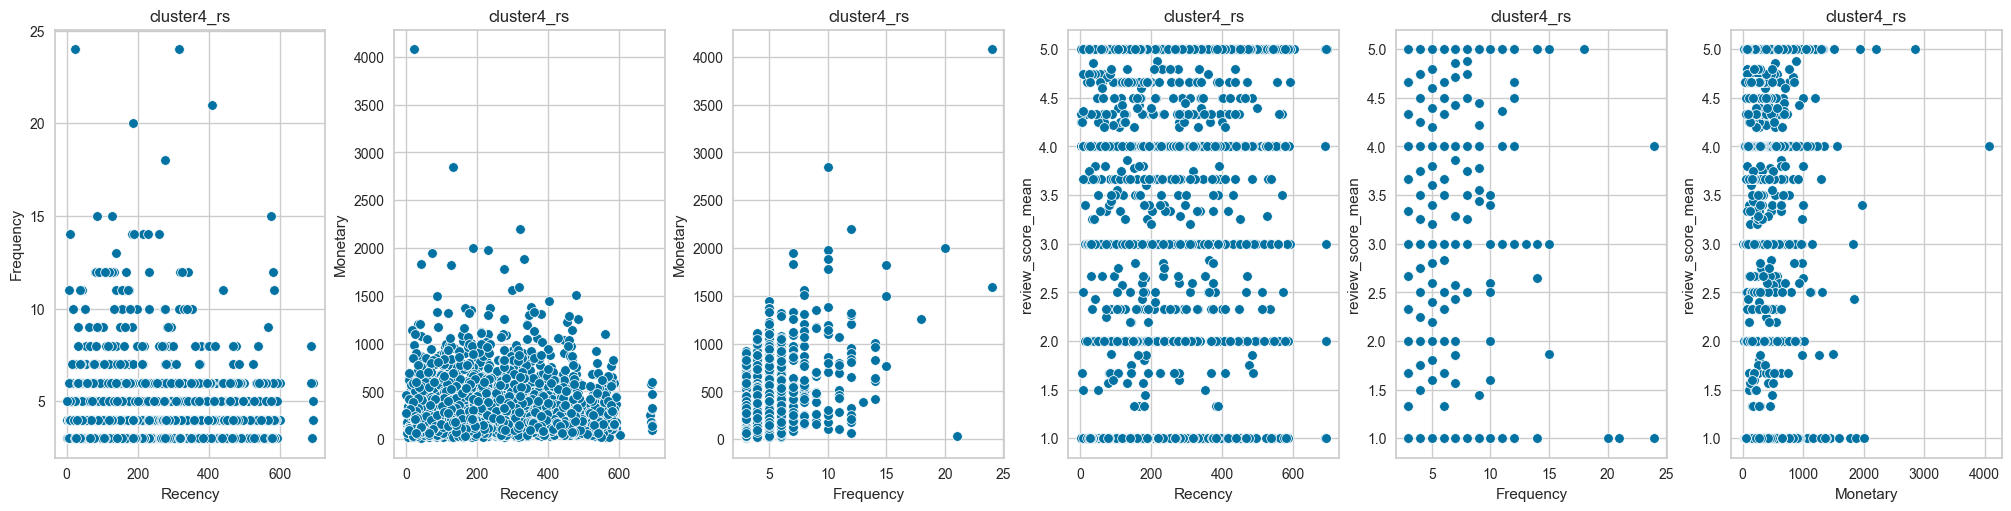

In [54]:
fpairplot(cluster0_rs, lists1, 'cluster0_rs')
plt.show()
fpairplot(cluster1_rs, lists1, 'cluster1_rs')
plt.show()
fpairplot(cluster2_rs, lists1, 'cluster2_rs')
plt.show()
fpairplot(cluster3_rs, lists1, 'cluster3_rs')
plt.show()
fpairplot(cluster4_rs, lists1, 'cluster4_rs')
plt.show()

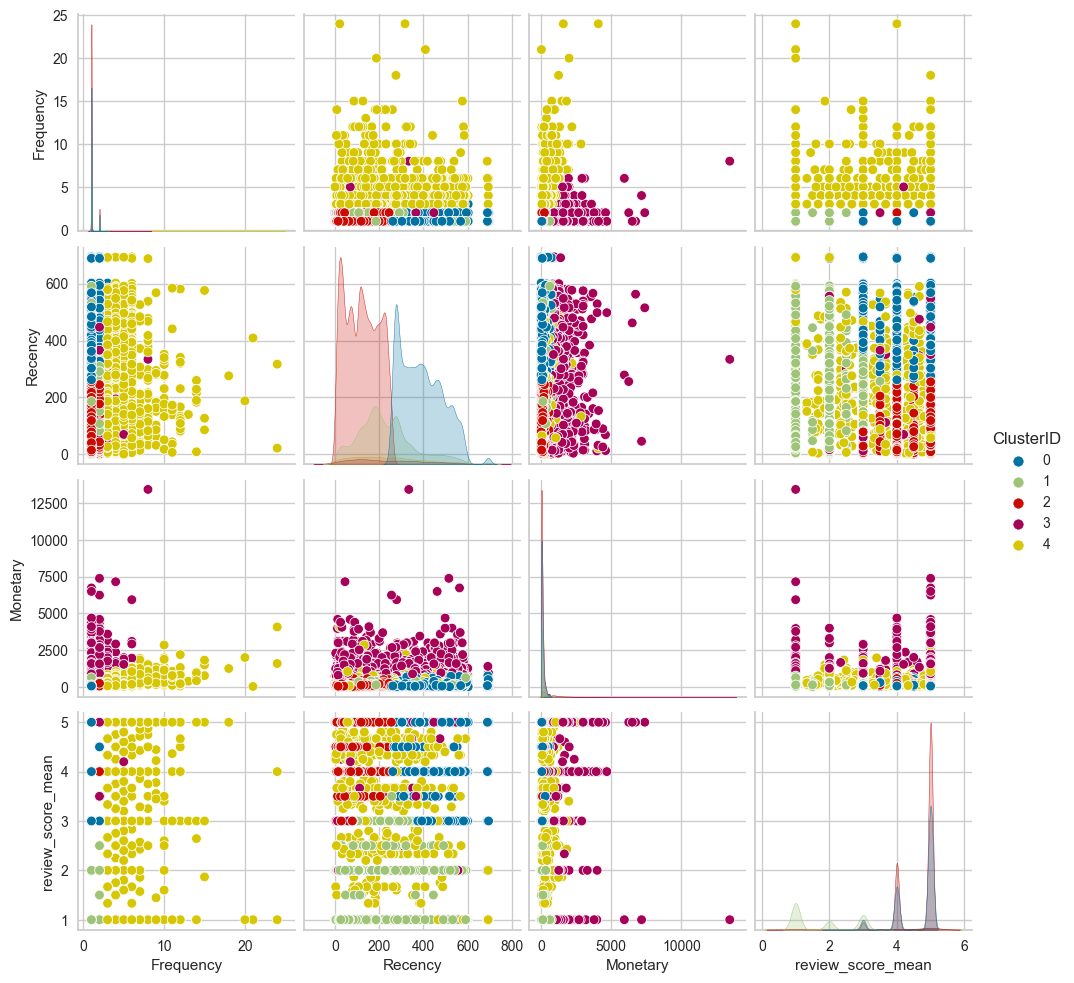

In [55]:
data1 = RFMS_km[['ClusterID', 'Frequency',
                 'Recency', 'Monetary', 'review_score_mean']]
sns.pairplot(data1, hue='ClusterID',
             palette=sns.color_palette(n_colors=5))

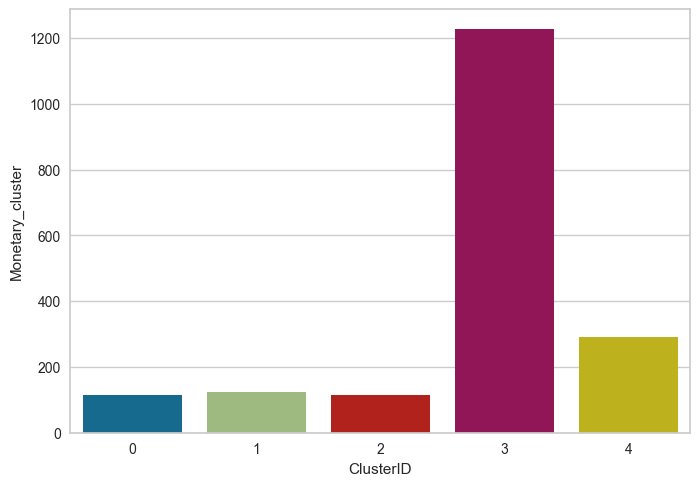

****************************************************************************************************


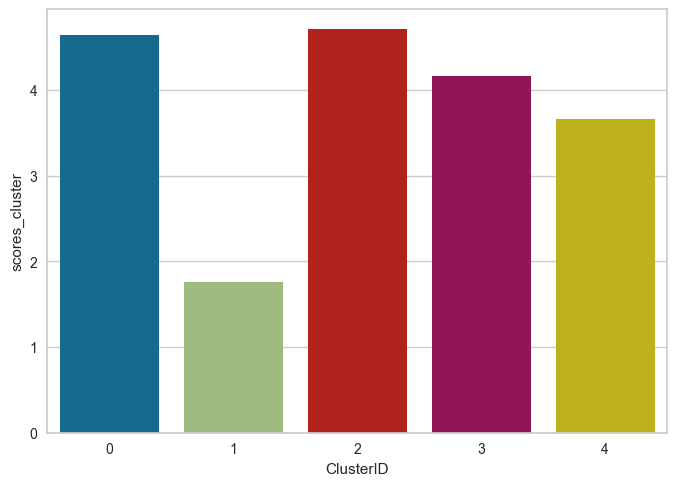

****************************************************************************************************


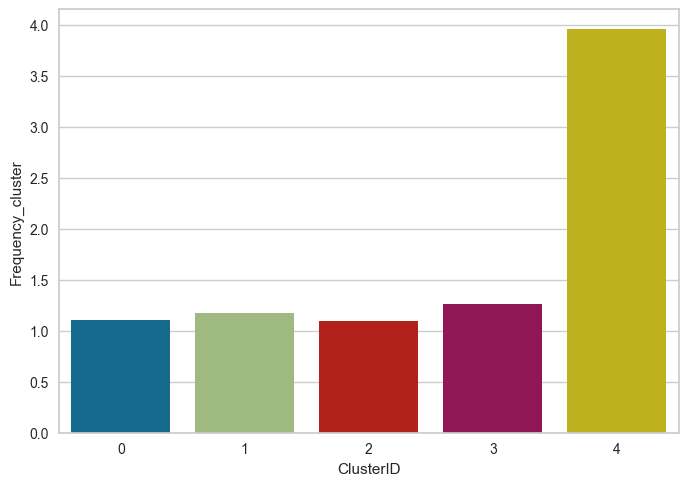

****************************************************************************************************


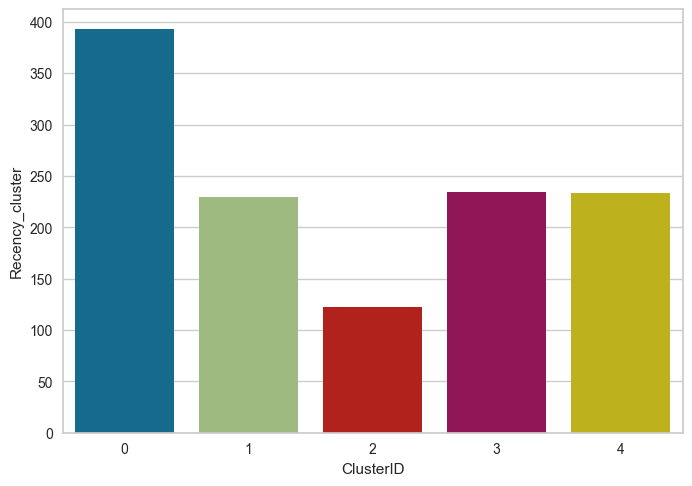

In [120]:
fig = plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Monetary_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.scores_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Frequency_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Recency_cluster)
plt.show()

**Observations**<br>
-cluster 0:les clients les plus anciens et les  satisfaits<br>
-cluster1:les clients sont les plus mécontents<br>
-cluster2:les clients les plus récents et  satisfaits <br>
-<b>cluster 3:<font color='red'>les clients avec les montants lesplus élevés, et satisfaits et anciens:poetntiel client</font>
    <br>
 -cluster4:anciens clients qui ont achetés fréquement et satisfaits

#### Caractérisation des clients (RFM+score)

In [79]:
customer_types2 = ['clients perdus', ' client mécontent',
                   ' nouveau client satisfait', 'potentiel client', 'client occasionnel']
rfm_score_caracte = ['clients  les plus anciens avec faible fréquence , faibles dépenses et satisfaits',
                     'clients anciens avec faibles fréquence et dépenses.pas satisfait',
                     'client les plus récents,et satisfaits ',
                     'client avec des dépenses importantes et satisfais et ça faits longtemps qu\'ils n\'ont pas commandés',
                     'clients anciens qui ont achetés fréquemment avec des montants bas et satistafits'
                     ]
d2 = {'Cluster': list(range(0, 5)), 'Type de client': customer_types2,
      'Caractéristiques Kmeans RFM+score': rfm_score_caracte}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res2 = pd.DataFrame(d2)
res2

Cluster       Type de client        \
0     0                clients perdus   
1     1              client mécontent   
2     2      nouveau client satisfait   
3     3              potentiel client   
4     4            client occasionnel   

                                   Caractéristiques Kmeans RFM+score                                   
0                    clients  les plus anciens avec faible fréquence , faibles dépenses et satisfaits  
1                                    clients anciens avec faibles fréquence et dépenses.pas satisfait  
2                                                              client les plus récents,et satisfaits   
3  client avec des dépenses importantes et satisfais et ça faits longtemps qu'ils n'ont pas commandés  
4                    clients anciens qui ont achetés fréquemment avec des montants bas et satistafits

In [ ]:
df1.columns

### 3.3.DBSCAN (RFM)<a class="anchor" id="db"></a>

<IPython.core.display.Javascript object>


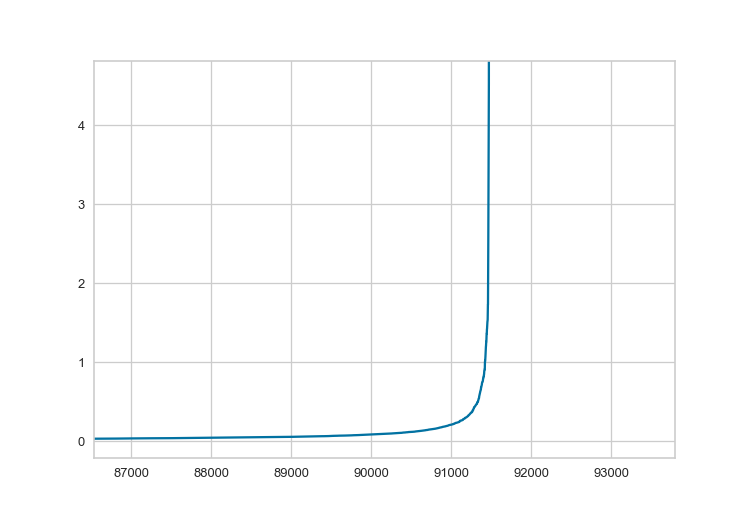

In [76]:
from sklearn.neighbors import NearestNeighbors
%matplotlib notebook
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(Xstd)
distances, indices = neighbors_fit.kneighbors(Xstd)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)

In [123]:
Xstd_dbscan = Xstd.copy()

In [133]:
EPS = [0.2, 0.35, 0.45, 0.55, 0.65, 0.75, 0.9]
for e in EPS:
    db = DBSCAN(eps=e, min_samples=10).fit(Xstd_dbscan)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(e)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("cutomers not associated to  clusters: %d" % n_noise_)

    dbscan_km = pd.concat([RFM, pd.Series(labels)], axis=1)
    dbscan_km.columns = ['CustomerID', 'Frequency',
                         'Recency', 'Monetary', 'ClusterID']
    cust_per_clust_dbscan = fnb_customper_cluster(dbscan_km)
    print(cust_per_clust_dbscan)
    print('*'*100)

0.2
Estimated number of clusters: 29
cutomers not associated to  clusters: 1768
    ClusterID  nb_customers
0          -1          1768
1           0         77528
2           1          9624
3           2           554
4           3           198
5           4          1459
6           5            27
7           6            20
8           7            13
9           8            31
10          9            15
11         10             7
12         11            20
13         12            11
14         13            11
15         14            26
16         15            10
17         16            13
18         17            11
19         18            16
20         19            10
21         20            18
22         21            11
23         22            13
24         23            11
25         24            13
26         25             8
27         26            10
28         27            11
29         28            11
****************************************************

In [291]:
from sklearn.neighbors import NearestNeighbors

**Observation**<br>
Pour les différentes valeurs d'eps testés ,les clusters proposés ne contiennent pas suffisament de clients.Du coup l'analyse graphique métier n'est pas utile.Ceci démontre que le dbscan n'est pas approprié.Intuitivement cela s'explique par le fait que le dbscan fonctionne par densité et que dans notre cas la densité des 3% bons client(qui ont commandé plusieurs fois) est faible

### 3.4.DBSCAN (RFM+review_score)<a class="anchor" id="db1"></a>

In [77]:
neighbors1 = NearestNeighbors(n_neighbors=10)
neighbors_fit1 = neighbors1.fit(Xstd1)
distances1, indices1 = neighbors_fit1.kneighbors(Xstd1)
distances = np.sort(distances1, axis=0)
distances1 = distances1[:, 1]

plt.plot(distances1)

NameError: name 'Xstd1' is not defined

In [296]:
Xstd1.columns

Index(['Frequency', 'Recency', 'Monetary', 'review_score_mean'], dtype='object')

In [297]:
Xstd1_dbscan = Xstd1.copy()
EPS = [0.2, 0.35, 0.45, 0.55, 0.65, 0.75, 0.9]
for e in EPS:

    db1 = DBSCAN(eps=e, min_samples=10).fit(Xstd1_dbscan)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels1 = db1.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters1_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
    n_noise1_ = list(labels1).count(-1)
    print(e)
    print("Estimated number of clusters: %d" % n_clusters1_)
    print("cutomers not associated to  clusters: %d" % n_noise1_)

    dbscan_km1 = pd.concat([RFM_score_review, pd.Series(labels1)], axis=1)
    dbscan_km1.columns = ['CustomerID', 'Frequency',
                          'Recency', 'Monetary', 'review_score_mean', 'ClusterID']
    cust_per_clust_dbscan1 = fnb_customper_cluster(dbscan_km1)
    print(cust_per_clust_dbscan1)
    print('*'*100)

0.2
Estimated number of clusters: 61
cutomers not associated to  clusters: 4473
    ClusterID  nb_customers
0      -1           4473   
1       0          46603   
2       1          15385   
3       2           6132   
4       3           1360   
..        ...           ...
57     56             12   
58     57             13   
59     58             17   
60     59             10   
61     60              8   

[62 rows x 2 columns]
****************************************************************************************************
0.35
Estimated number of clusters: 41
cutomers not associated to  clusters: 2335
    ClusterID  nb_customers
0      -1           2335   
1       0          46948   
2       1          15663   
3       2           6261   
4       3           1439   
5       4           6501   
6       5            158   
7       6            408   
8       7            889   
9       8            278   
10      9           1565   
11     10           4986   
12     11      

In [165]:
# start_db = time.time()
# dbscan = DBSCAN(eps=0.65, min_samples=10).fit(Xstd_dbscan)
# labels = dbscan.labels_
# elapsedtime_dbscan = time.time()-start_db
# silh_sc_dbscan = silhouette_score(Xstd_dbscan, labels)
# print(f"DBSCAN Silhouette Coefficient :{silh_sc_dbscan}")

# print(f"Dbscan elapsed time : {elapsedtime_dbscan}")
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)
# # print(f"DBSCAN estimated number of clusters: {n_clusters_}" )
# print(f"DBSCAN cutomers not associated to  clusters: {n_noise_}" )
# pr_noise=100*n_noise_/Xstd_dbscan.shape[0]
# print(f"% DBSCAN cutomers not associated to  clusters : {pr_noise}%" )
# print('*'*100)
# dbscan_km = pd.concat([RFM, pd.Series(labels)], axis=1)
# dbscan_km.columns = ['CustomerID', 'Frequency',
#                   'Recency', 'Monetary', 'ClusterID']
# dbscan_km

### 3.5.Mini batch kmeans (RFM)<a class="anchor" id="ag"></a>

#### Choix de k

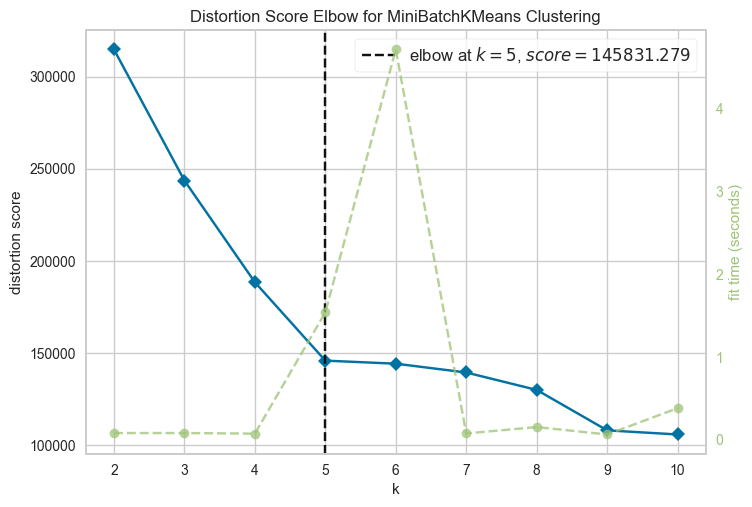

In [76]:
batch_size = 50
fkelbowvis(MiniBatchKMeans(batch_size=batch_size), range(2, 11), Xstd)

**Observations**<br>
ici la méthode de elbow donne k=5.le graphe change à,chaque fois du au choix aléatoires des échantillons

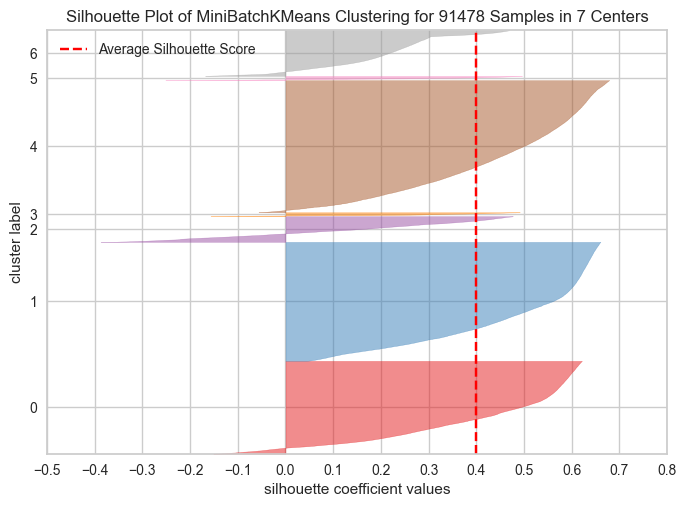

In [192]:
fsilhouettevis(MiniBatchKMeans(n_clusters=7, batch_size=batch_size), Xstd)

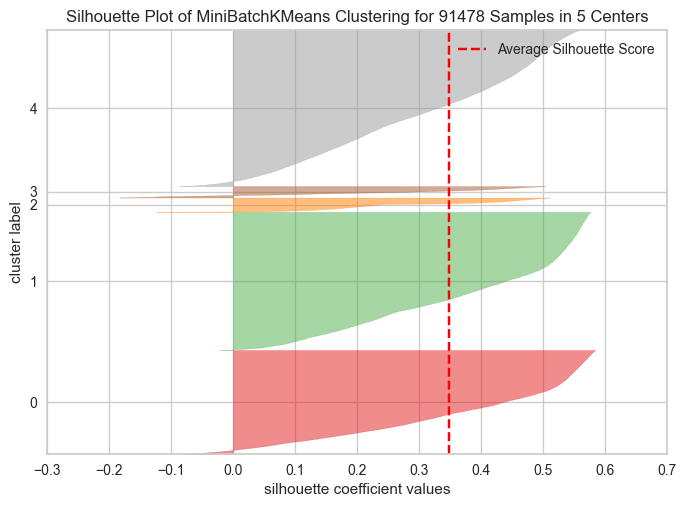

In [193]:
fsilhouettevis(MiniBatchKMeans(n_clusters=5, batch_size=batch_size), Xstd)

In [298]:
fsilhouettevis(MiniBatchKMeans(n_clusters=9, batch_size=batch_size), Xstd)

In [173]:
k_selected3 = 5
start_batch = time.time()
mbk = MiniBatchKMeans(n_clusters=k_selected3, batch_size=batch_size)
elapsed_time_batch = time.time()-start_batch
y_minikmeans = mbk.fit_predict(Xstd)

In [169]:
print(f"Mini batch kmeans elapsed time {elapsed_time_batch}")

Mini batch kmeans elapsed time 0.0


In [265]:
elapsed_time_batch2 = format(float(elapsed_time_batch), ".10f")
elapsed_time_batch

0.0

In [82]:
silhouette_score_minik = silhouette_score(Xstd, y_minikmeans)
print(f"Mini batch kmeans silhouette score {silhouette_score_minik}")

Mini batch kmeans silhouette score 0.2648039330894385


In [171]:
RFM_minikmeans = add_cluster_data(RFM, y_minikmeans, ['CustomerID', 'Frequency',  'Recency',
                                                      'Monetary', 'ClusterID'])
RFM_minikmeans

CustomerID  Frequency  Recency  Monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      112    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      115     18.90   
2      0000f46a3911fa3c0805444483337064          1      537     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1      321     25.99   
4      0004aac84e0df4da2b147fca70cf8255          1      288    180.00   
...                                 ...        ...      ...       ...   
91473  fffcf5a5ff07b0908bd4e2dbc735a684          2      447   1570.00   
91474  fffea47cd6d3cc0a88bd621562a9d061          1      262     64.89   
91475  ffff371b4d645b6ecea244b27531430a          1      568     89.90   
91476  ffff5962728ec6157033ef9805bacc48          1      119    115.00   
91477  ffffd2657e2aad2907e67c3e9daecbeb          1      484     56.99   

       ClusterID  
0              3  
1              3  
2              4  
3              1  
4              1  
...          ...  
91473          0  
91474          1  
91475          4  
91476          3  
91477          4  

[91478 rows x 5 columns]

In [83]:
RFM_minikmeans = pd.concat([RFM, pd.Series(y_minikmeans)], axis=1)
RFM_minikmeans.columns = ['CustomerID', 'Frequency',  'Recency',
                          'Monetary', 'ClusterID']

RFM_minikmeans

CustomerID  Frequency  Recency  Monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      112    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      115     18.90   
2      0000f46a3911fa3c0805444483337064          1      537     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1      321     25.99   
4      0004aac84e0df4da2b147fca70cf8255          1      288    180.00   
...                                 ...        ...      ...       ...   
91473  fffcf5a5ff07b0908bd4e2dbc735a684          2      447   1570.00   
91474  fffea47cd6d3cc0a88bd621562a9d061          1      262     64.89   
91475  ffff371b4d645b6ecea244b27531430a          1      568     89.90   
91476  ffff5962728ec6157033ef9805bacc48          1      119    115.00   
91477  ffffd2657e2aad2907e67c3e9daecbeb          1      484     56.99   

       ClusterID  
0              2  
1              2  
2              0  
3              3  
4              3  
...          ...  
91473          4  
91474          3  
91475          0  
91476          2  
91477          0  

[91478 rows x 5 columns]

#### Interprétation des clusters

In [84]:
cust_per_clust_minikmeans = fnb_customper_cluster(RFM_minikmeans)
print(cust_per_clust_minikmeans)

   ClusterID  nb_customers
0          0         15877
1          1         13475
2          2         31833
3          3         23081
4          4          7212


In [174]:
cluster0_minik = RFM_minikmeans[RFM_minikmeans.ClusterID == 0]
cluster1_minik = RFM_minikmeans[RFM_minikmeans.ClusterID == 1]
cluster2_minik = RFM_minikmeans[RFM_minikmeans.ClusterID == 2]
cluster3_minik = RFM_minikmeans[RFM_minikmeans.ClusterID == 3]
cluster4_minik = RFM_minikmeans[RFM_minikmeans.ClusterID == 4]

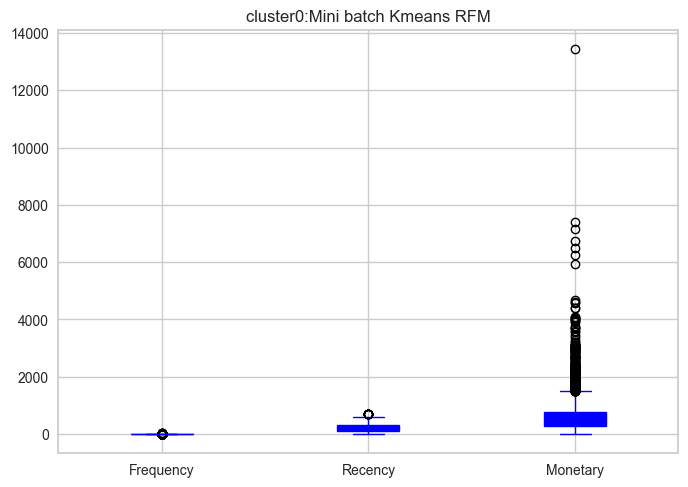

In [175]:
boxplot_per_cluster(cluster0_minik, ['Frequency', 'Recency', 'Monetary'],
                    'cluster0:Mini batch Kmeans RFM')

**Observations**<br>
Cluster0: clients qui ont achetés peu de fois avec des montants faibles et ils sont récents.

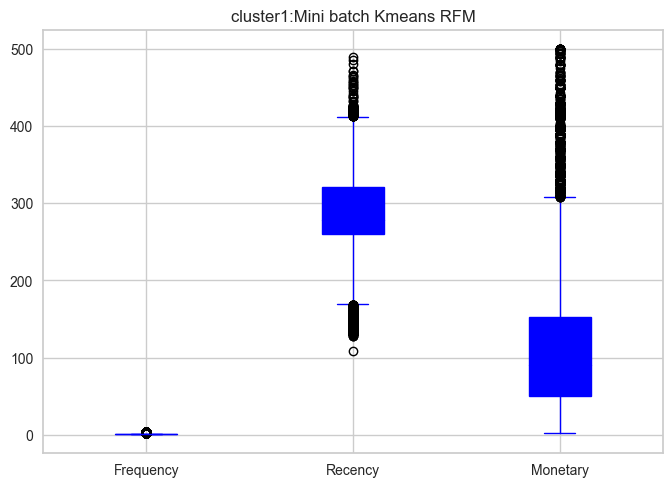

In [176]:
boxplot_per_cluster(cluster1_minik, ['Frequency', 'Recency', 'Monetary'],
                    'cluster1:Mini batch Kmeans RFM')

**Observations**<br>
cluster1:clients qui ont achetés peu de fois avec des dépenses faibles.ça fait longtemps qu'ils ont passé une commande.

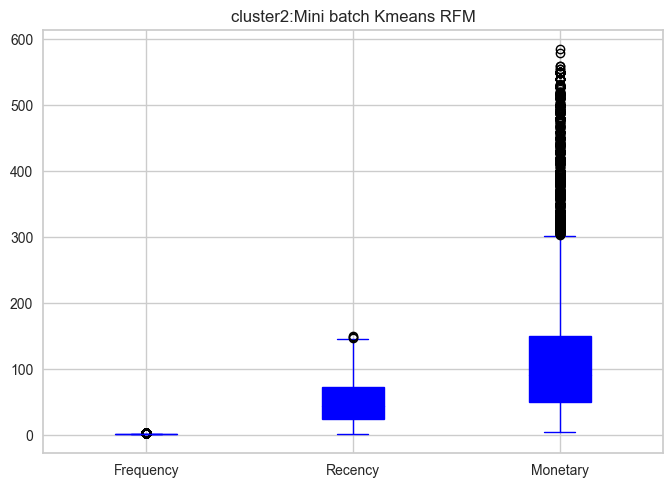

In [177]:
boxplot_per_cluster(cluster2_minik, ['Frequency', 'Recency', 'Monetary'],
                    'cluster2:Mini batch Kmeans RFM')

**Observations**<br>
Cluster2:Clients récents achtés peu de fois avec des montants faibles

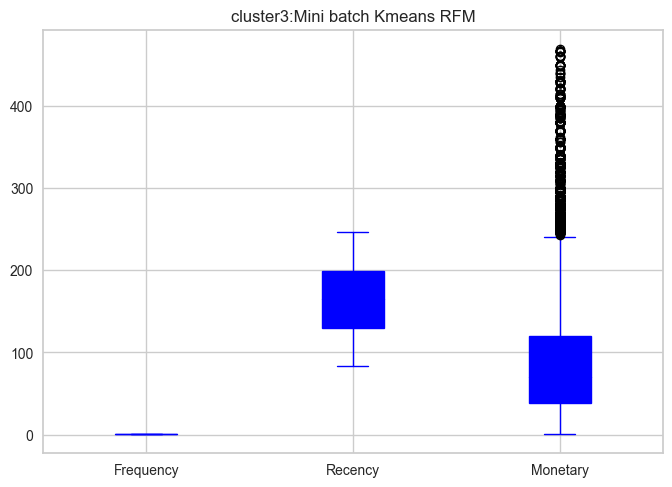

In [178]:
boxplot_per_cluster(cluster3_minik, ['Frequency', 'Recency', 'Monetary'],
                    'cluster3:Mini batch Kmeans RFM')

**Observations**<br>
cluster2:clients achetant peu de fois avec des montants faibles et ça fait longtemps qu'ils ont achétes.

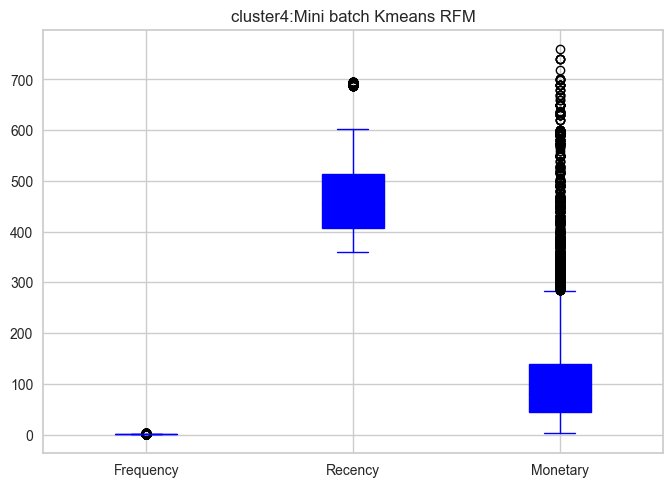

In [179]:
boxplot_per_cluster(cluster4_minik, ['Frequency', 'Recency', 'Monetary'],
                    'cluster4:Mini batch Kmeans RFM')

In [1]:
#boxplot_cluster3_minik = cluster3_minik.boxplot(
#    column=['Frequency', 'Recency', 'Monetary'], color='red', patch_artist=True)
#plt.title('cluster3_mini batch kmeans')

**Observation**<br>
cluster3:les plus récents avec faibel fréquence et montants

**Observations**<br>
cluster4: clients anciens achetant peu de fois et avec des montants faibles.

<AxesSubplot: title={'center': 'Frequency'}, xlabel='ClusterID'>

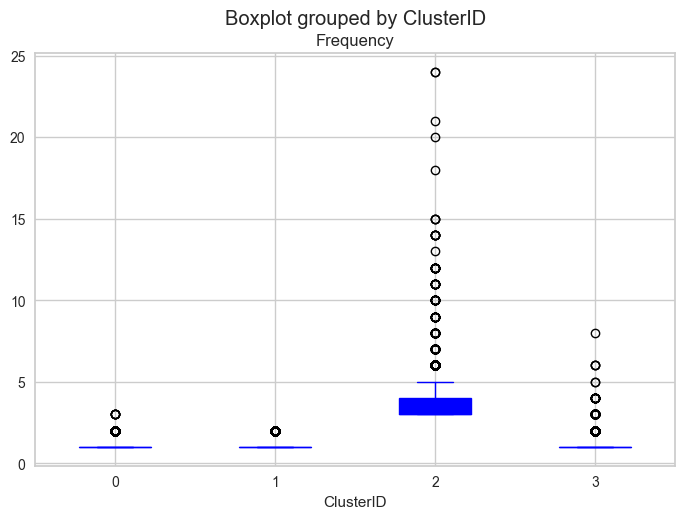

In [51]:
RFM_minikmeans.boxplot(column='Frequency', by='ClusterID',
                       color='blue', patch_artist=True)

**Observations**<br>
cluster2:Clients qui ont commandés plusieurs fois

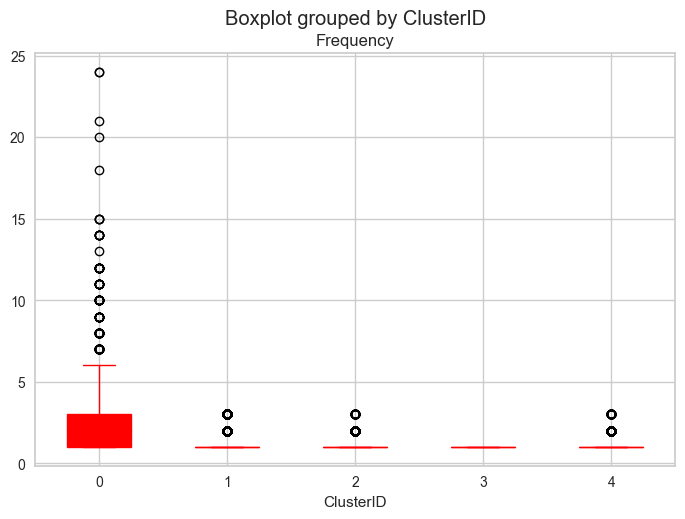

In [180]:
boxplot_per_feature(RFM_minikmeans, 'Frequency')

**Observations**<br>
cluster0:clients qui ont achetés plusieurs fois

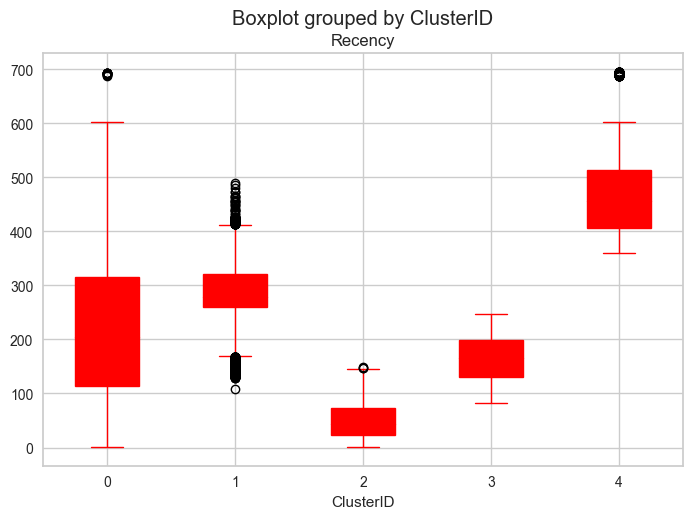

In [181]:
boxplot_per_feature(RFM_minikmeans, 'Recency')

**Observations**<br>
cluster2:clients les plus récents

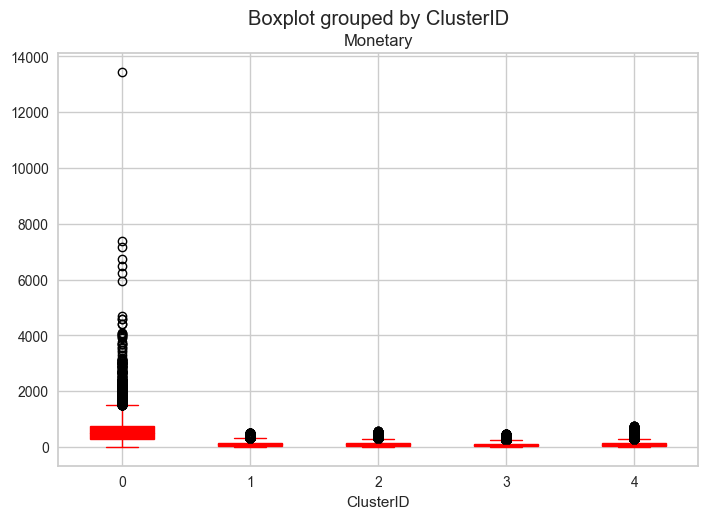

In [182]:
boxplot_per_feature(RFM_minikmeans, 'Monetary')

**Observations**<br>
cluster0:clients avec des montants les plus élévés.

In [326]:
RFM_minikmeans.head()

CustomerID             Frequency  Recency  Monetary  ClusterID
0  0000366f3b9a7992bf8c76cfdf3221e2      1        112     129.90       3    
1  0000b849f77a49e4a4ce2b2a4ca5be3f      1        115      18.90       3    
2  0000f46a3911fa3c0805444483337064      1        537      69.00       4    
3  0000f6ccb0745a6a4b88665a16c9f078      1        321      25.99       1    
4  0004aac84e0df4da2b147fca70cf8255      1        288     180.00       1

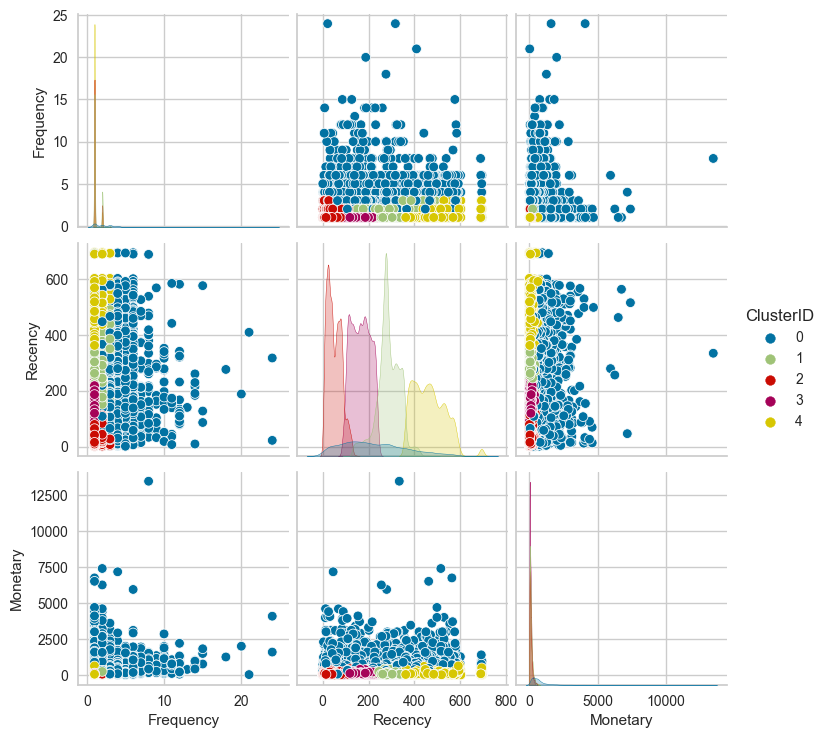

In [327]:
data3 = RFM_minikmeans[['ClusterID', 'Frequency',  'Recency', 'Monetary']]
sns.pairplot(data3, hue='ClusterID',
             palette=sns.color_palette(n_colors=5))

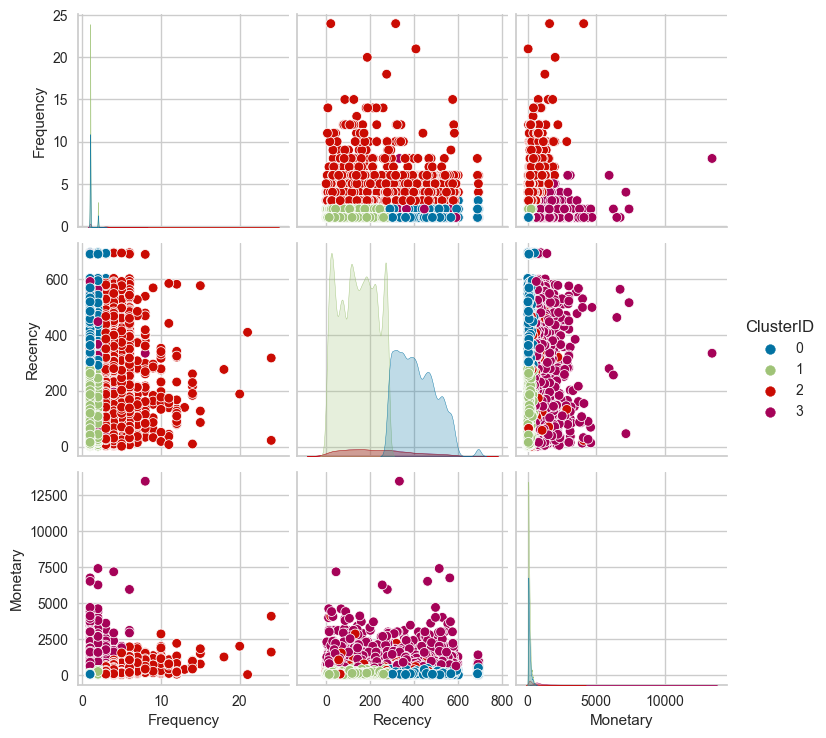

In [55]:
data2 = RFM_minikmeans[['ClusterID', 'Frequency',  'Recency', 'Monetary']]
sns.pairplot(data2, hue='ClusterID',
             palette=sns.color_palette(n_colors=4))

In [184]:
minik_recency_clusters = mean_clus_feat(RFM_minikmeans, 'ClusterID', 'Recency')
minik_frequency_clusters = mean_clus_feat(
    RFM_minikmeans, 'ClusterID', 'Frequency')
minik_monetary_clusters = mean_clus_feat(
    RFM_minikmeans, 'ClusterID', 'Monetary')

In [185]:
df3 = pd.concat([pd.Series([0, 1, 2, 3]), minik_recency_clusters,
                minik_frequency_clusters, minik_monetary_clusters], axis=1)
df3.columns = ["ClusterID", "Recency_cluster",
               "Frequency_cluster", "Monetary_cluster"]
df3

ClusterID  Recency_cluster  Frequency_cluster  Monetary_cluster
0        0.0       223.745115           2.488661        611.799304
1        1.0       284.978671           1.224966        114.704205
2        2.0        50.157415           1.134458        116.797534
3        3.0       165.511865           1.000000         88.304390
4        NaN       463.220060           1.075545        109.238154

<AxesSubplot: xlabel='ClusterID', ylabel='Monetary_cluster'>

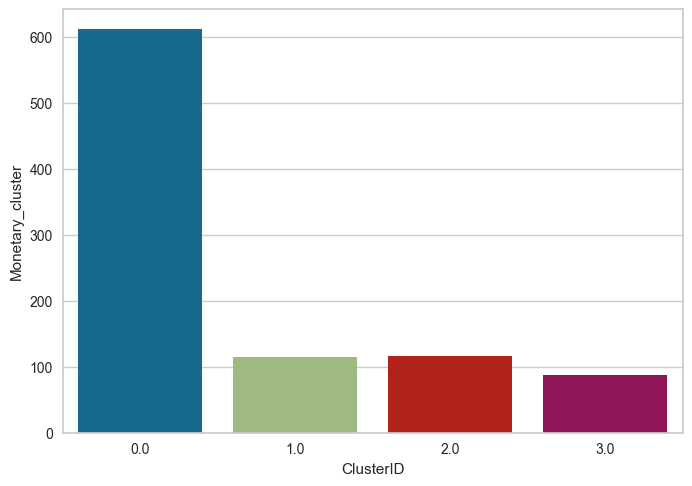

In [186]:
sns.barplot(x=df3.ClusterID, y=df3.Monetary_cluster)

**Observations**<br>
cluster0:client avec les montants les plus élevés

<AxesSubplot: xlabel='ClusterID', ylabel='Frequency_cluster'>

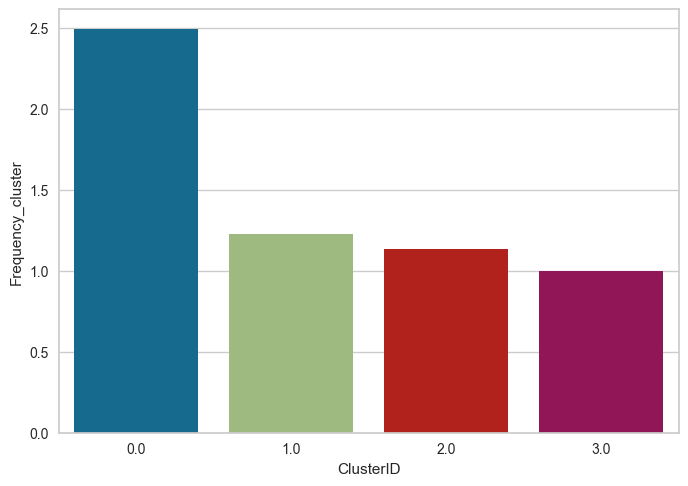

In [187]:
sns.barplot(x=df3.ClusterID, y=df3.Frequency_cluster)

**Observations**<br>
cluster0:client avec les fréquences les plus élevés

<AxesSubplot: xlabel='ClusterID', ylabel='Recency_cluster'>

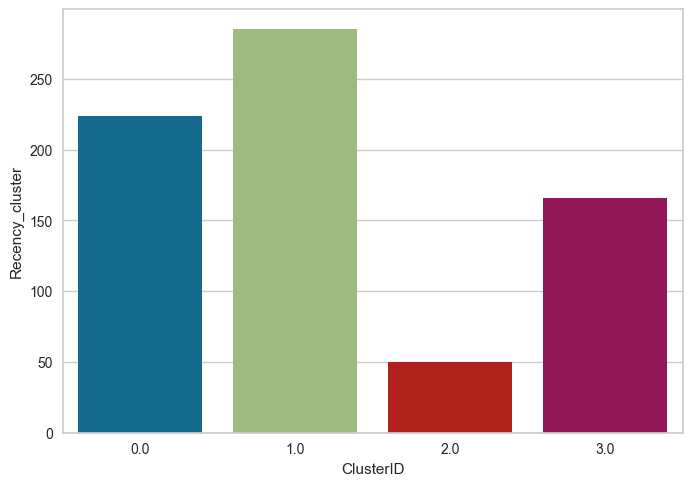

In [188]:
sns.barplot(x=df3.ClusterID, y=df3.Recency_cluster)

**Observations**<br>
cluster2:client avec les plus récents

#### Catégorisation des clients( Mini batch: RFM)

In [78]:
customer_types3 = ['client occasionnel', ' client perdu',
                   ' nouveau client ', 'xx', 'xx']
rfm_mini_caracte = ['clients avec des dépenses importantes et ça faits longtemps qu\'ils n\'ont pas commandés',
                    'clients   anciens avec faible fréquence , faibles dépenses ',

                    'client les plus récents',
                    'clients moins anciens avec faibles fréquence et dépenses',
                    'clients les plus anciens anciens'
                    ]
d3 = {'Cluster': list(range(0, 5)), 'Type de client': customer_types3,
      'Caractéristiques Mini Batch kmeans RFM': rfm_mini_caracte}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res3 = pd.DataFrame(d3)
res3

Cluster    Type de client    \
0     0     client occasionnel   
1     1           client perdu   
2     2        nouveau client    
3     3                     xx   
4     4                     xx   

                           Caractéristiques Mini Batch kmeans RFM                          
0  clients avec des dépenses importantes et ça faits longtemps qu'ils n'ont pas commandés  
1                             clients   anciens avec faible fréquence , faibles dépenses   
2                                                                 client les plus récents  
3                                clients moins anciens avec faibles fréquence et dépenses  
4                                                        clients les plus anciens anciens

### 3.6.Clustering avec Mini batch kmeans (RFM+review_score)<a class="anchor" id="kp"></a>

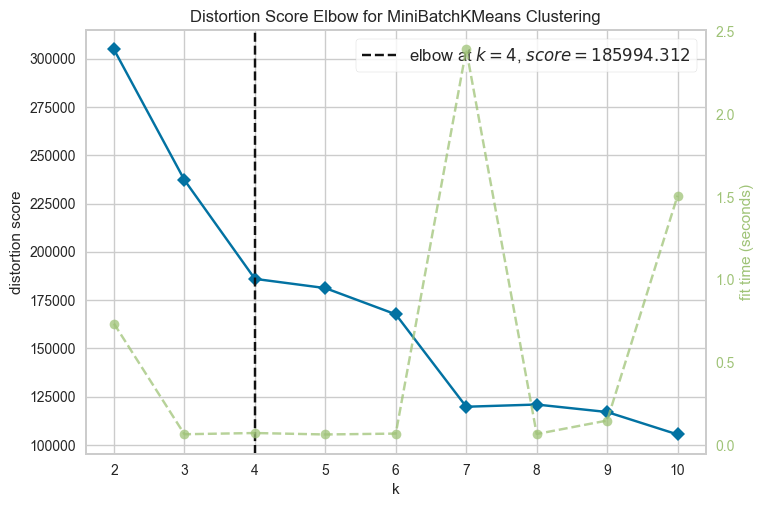

In [196]:
fkelbowvis(MiniBatchKMeans(batch_size=batch_size), range(2, 11), Xstd1)

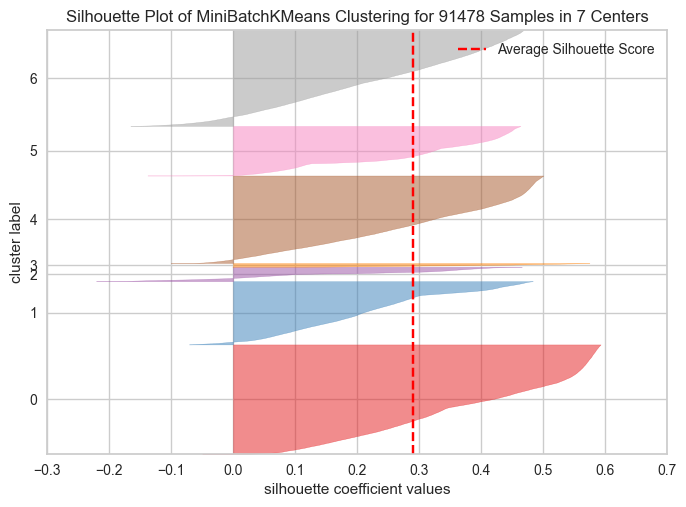

In [197]:
fsilhouettevis(MiniBatchKMeans(n_clusters=7, batch_size=batch_size), Xstd1)

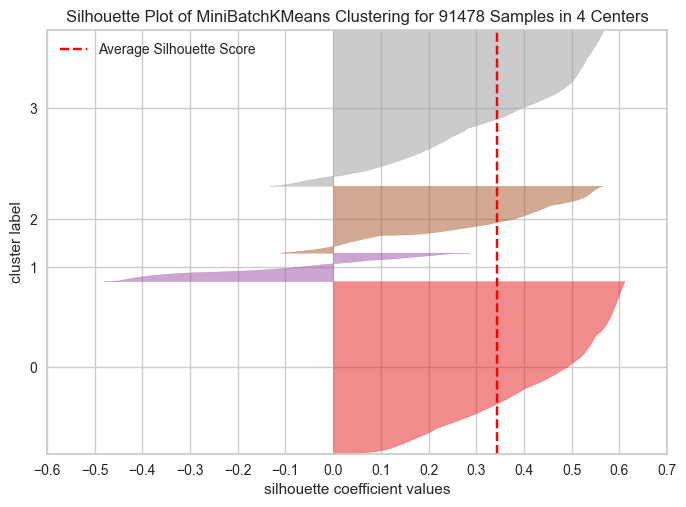

In [198]:
fsilhouettevis(MiniBatchKMeans(n_clusters=4, batch_size=batch_size), Xstd1)

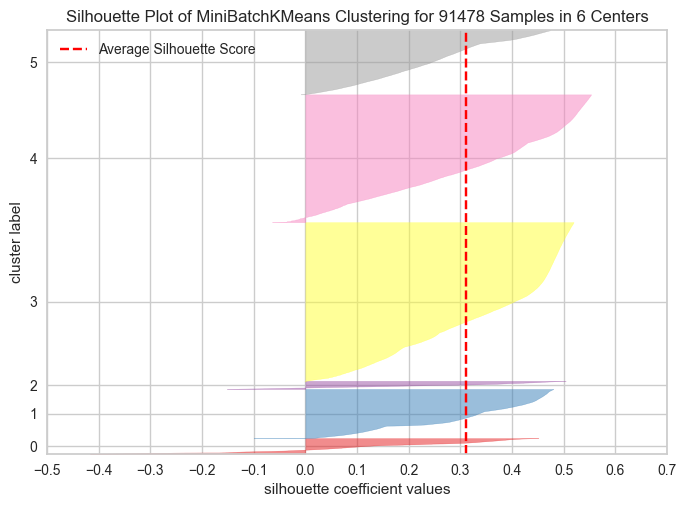

In [199]:
fsilhouettevis(MiniBatchKMeans(n_clusters=6, batch_size=batch_size), Xstd1)

start_batch2=time.time()
mbk2 = MiniBatchKMeans(n_clusters = 4,batch_size = batch_size)
elapsed_time_batch2=time.time()-start_batch
y_minikmeans2= mbk2.fit_predict(Xstd1) 
print(f"Mini batch kmeans elapsed time {elapsed_time_batch2}")

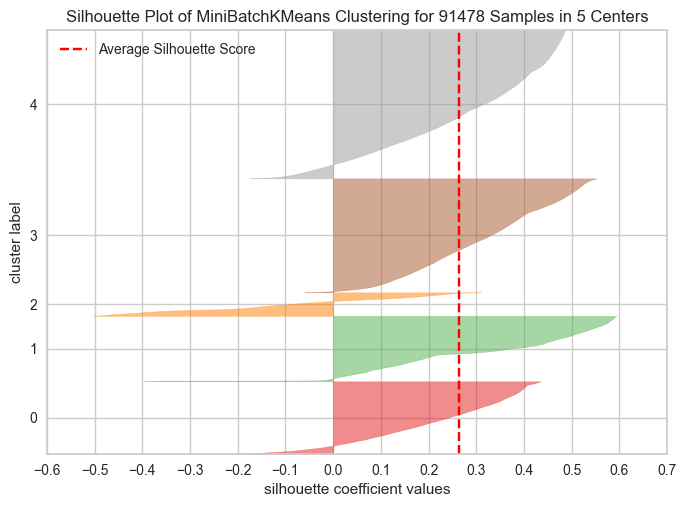

In [200]:
fsilhouettevis(MiniBatchKMeans(n_clusters=5, batch_size=batch_size), Xstd1)

In [11]:
k_selected4 = 6
start_batch2 = time.time()
mbk2 = MiniBatchKMeans(n_clusters=k_selected4, batch_size=batch_size)
elapsed_time_batch2 = time.time()-start_batch2
y_minikmeans2 = mbk2.fit_predict(Xstd1)

In [324]:
silhouette_score_minik2 = silhouette_score(Xstd1, y_minikmeans2)
print(f"Mini batch kmeans silhouette score {silhouette_score_minik2}")

Mini batch kmeans silhouette score 0.3716710316380884


In [15]:
RFM_score_review.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date', 'favorite_purshase_month', 'review_score_mean'],
      dtype='object')

#### Analyse des clusters

In [18]:
v=RFM_score_review[[['customer_unique_id','Frequency', 'Recency', 'Monetary','review_score_mean']]
RFMS_minikmeans = add_cluster_data(v, y_minikmeans2, ['CustomerID', 'Frequency',  'Recency','Monetary', 'review_score_mean', 'ClusterID'])
RFMS_minikmeans

SyntaxError: invalid syntax (293948917.py, line 2)

In [329]:
customer_per_cluster4 = fnb_customper_cluster(RFMS_minikmeans)
customer_per_cluster4

ClusterID  nb_customers
0      0          14712   
1      1          37571   
2      2           1368   
3      3           7462   
4      4           1444   
5      5          28921

In [330]:
cluster0_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 0]
cluster1_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 1]
cluster2_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 2]
cluster3_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 3]
cluster4_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 4]
cluster5_mb2 = RFMS_minikmeans[RFMS_minikmeans.ClusterID == 5]

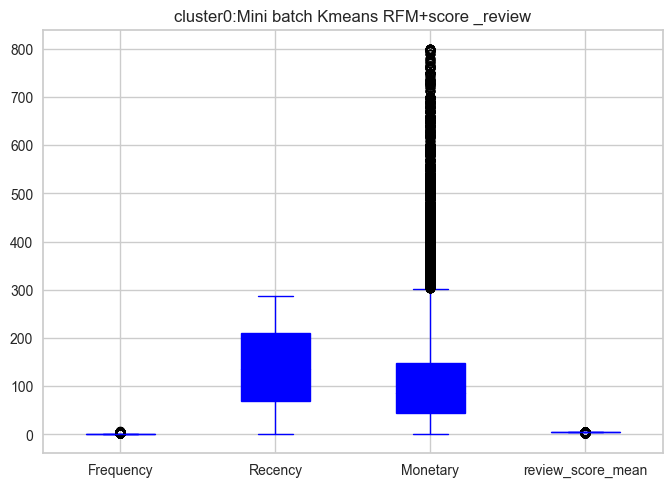

In [211]:
boxplot_per_cluster(cluster0_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster0:Mini batch Kmeans RFM+score _review')

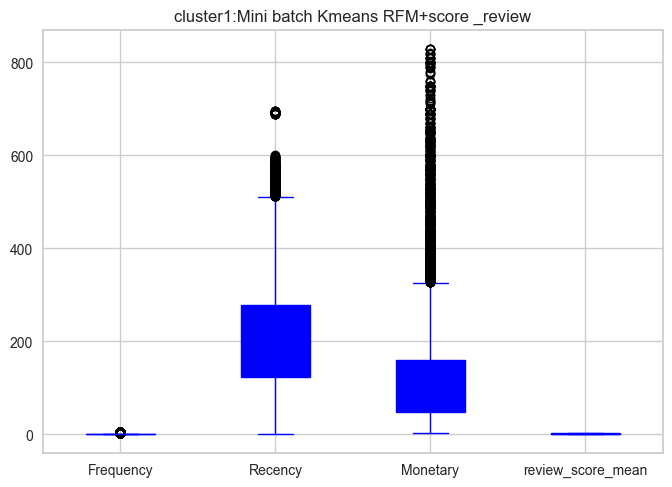

In [212]:
boxplot_per_cluster(cluster1_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster1:Mini batch Kmeans RFM+score _review')

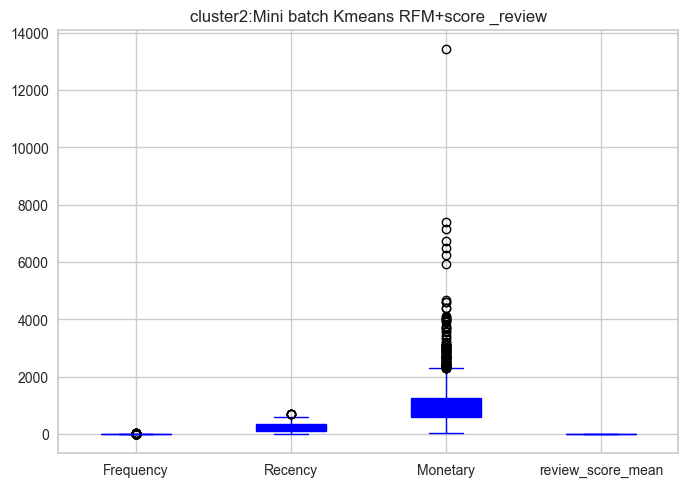

In [215]:
boxplot_per_cluster(cluster2_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster2:Mini batch Kmeans RFM+score _review')

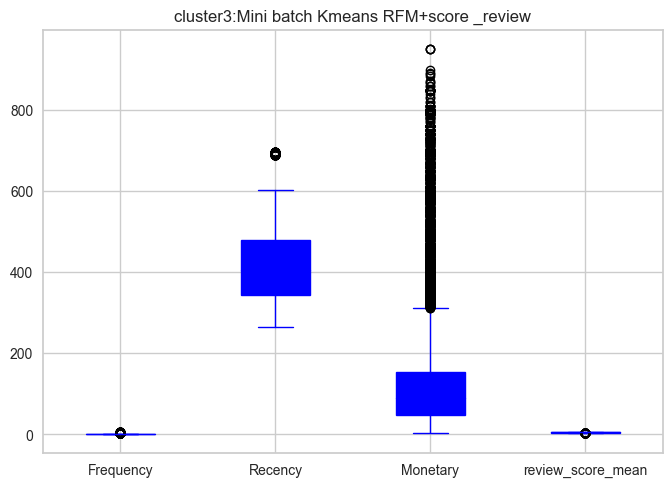

In [217]:
boxplot_per_cluster(cluster3_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster3:Mini batch Kmeans RFM+score _review')

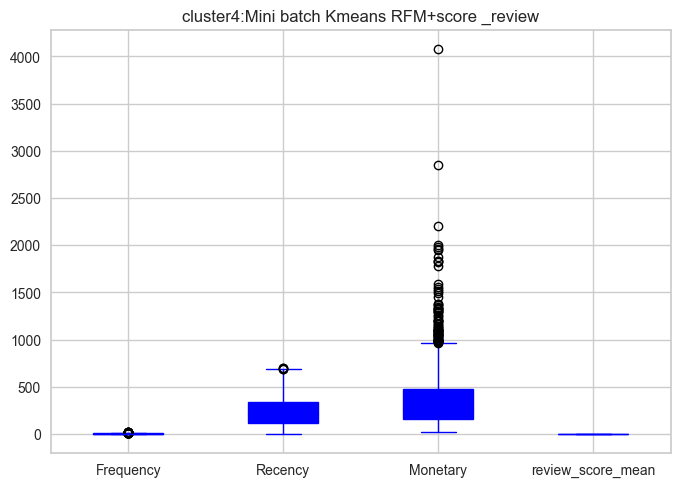

In [331]:
boxplot_per_cluster(cluster4_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster4:Mini batch Kmeans RFM+score _review')

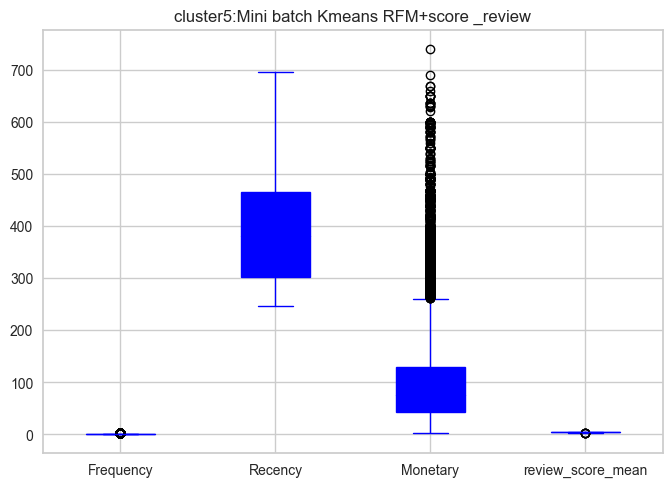

In [332]:
boxplot_per_cluster(cluster5_mb2, ['Frequency', 'Recency', 'Monetary', 'review_score_mean'],
                    'cluster5:Mini batch Kmeans RFM+score _review')

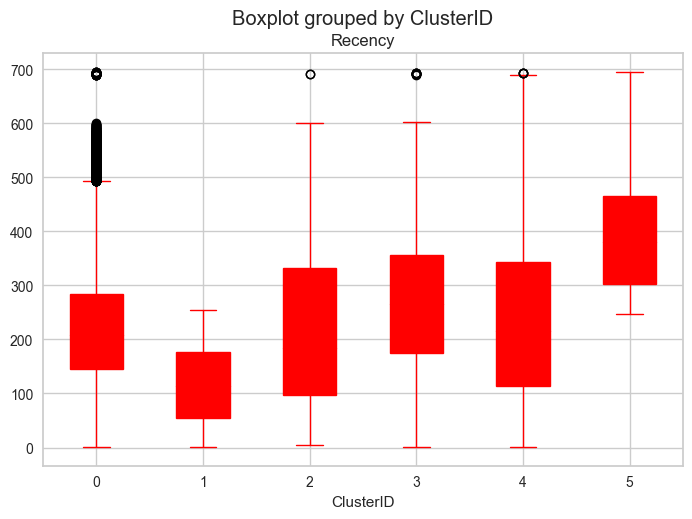

In [333]:
boxplot_per_feature(RFMS_minikmeans, 'Recency')

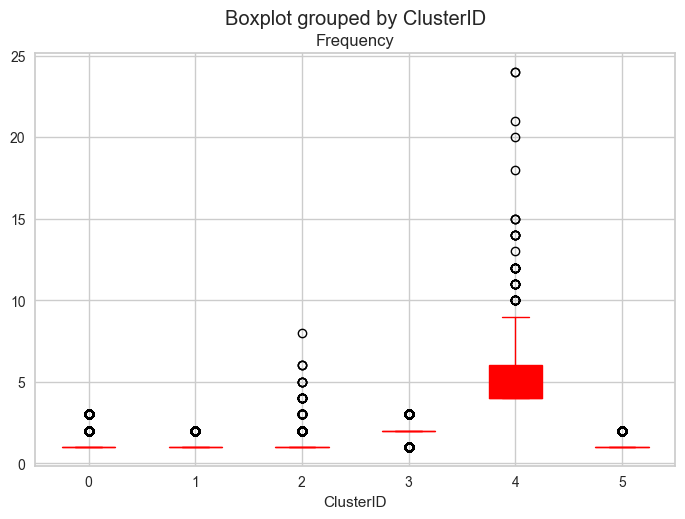

In [334]:
boxplot_per_feature(RFMS_minikmeans, 'Frequency')

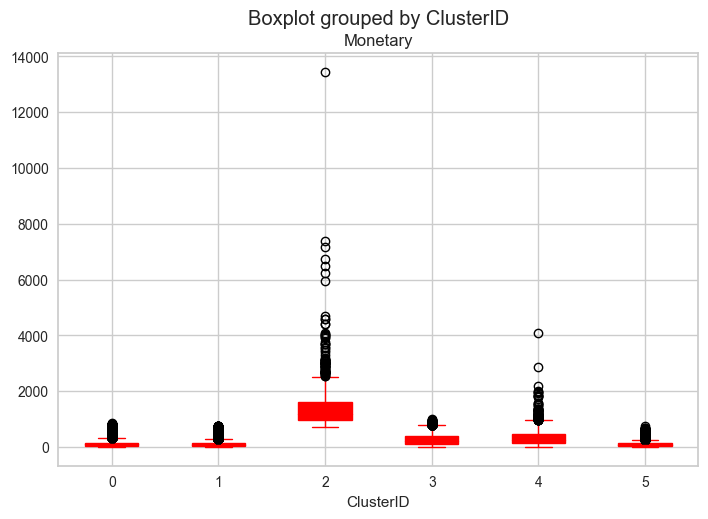

In [335]:
boxplot_per_feature(RFMS_minikmeans, 'Monetary')

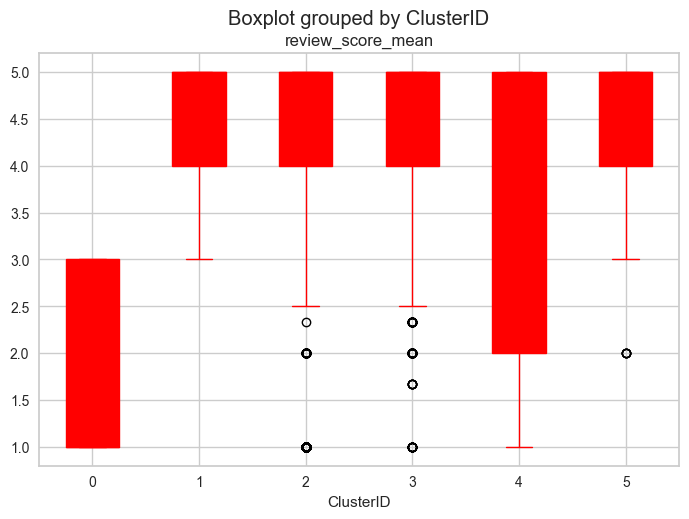

In [336]:
boxplot_per_feature(RFMS_minikmeans, 'review_score_mean')

In [337]:
minik_recency_clusters2 = mean_clus_feat(
    RFMS_minikmeans, 'ClusterID', 'Recency')
minik_frequency_clusters2 = mean_clus_feat(
    RFMS_minikmeans, 'ClusterID', 'Frequency')
minik_monetary_clusters2 = mean_clus_feat(
    RFMS_minikmeans, 'ClusterID', 'Monetary')
minik_score_clusters2 = mean_clus_feat(
    RFMS_minikmeans, 'ClusterID', 'review_score_mean')

In [340]:
df4 = pd.concat([pd.Series([0, 1, 2, 3, 4, 5]), minik_recency_clusters2,
                minik_frequency_clusters2, minik_monetary_clusters2, minik_score_clusters2], axis=1)
df4.columns = ["ClusterID", "Recency_cluster",
               "Frequency_cluster", "Monetary_cluster", "review_score_mean"]
df4

ClusterID  Recency_cluster  Frequency_cluster  Monetary_cluster  \
0      0        228.966490         1.201672           125.413687     
1      1        116.260946         1.044476           105.879771     
2      2        220.180556         1.260965          1392.229211     
3      3        267.413696         2.051059           275.412116     
4      4        238.884349         5.056094           366.794536     
5      5        390.942706         1.023236           101.905431     

   review_score_mean  
0      1.694207       
1      4.693979       
2      4.044115       
3      4.550791       
4      3.597536       
5      4.636406

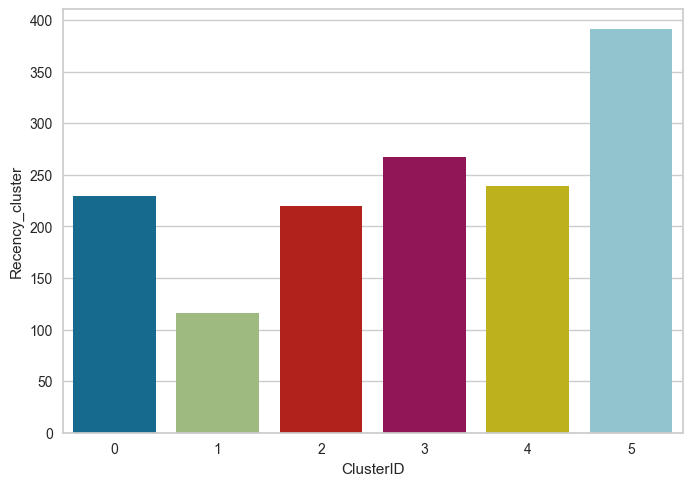

****************************************************************************************************


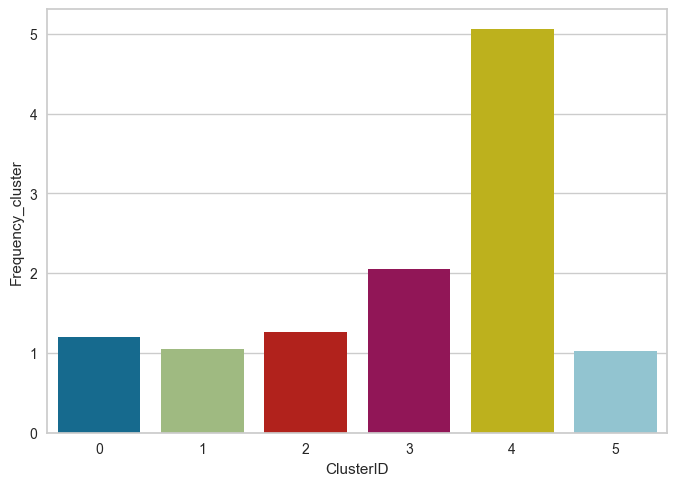

****************************************************************************************************


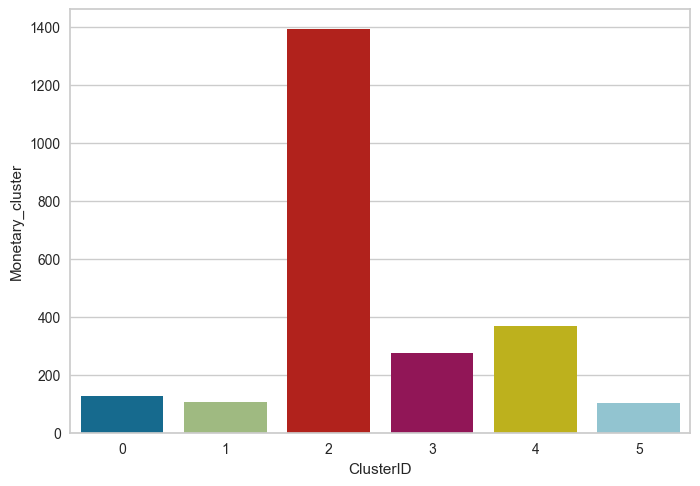

****************************************************************************************************


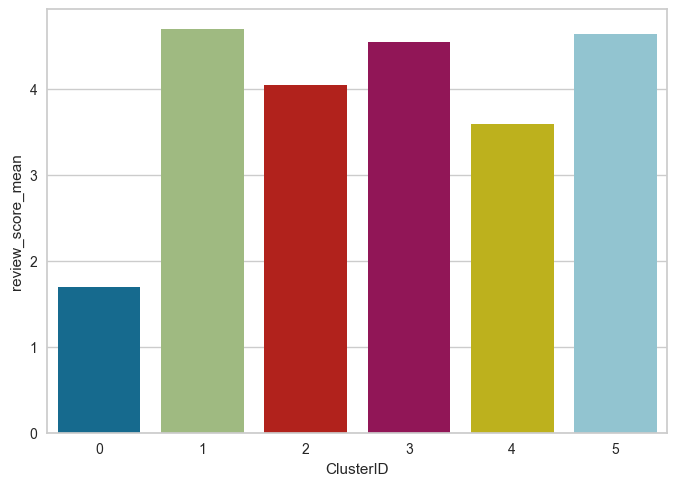

In [341]:
fig = plt.figure()
sns.barplot(x=df4.ClusterID, y=df4.Recency_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df4.ClusterID, y=df4.Frequency_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df4.ClusterID, y=df4.Monetary_cluster)
plt.show()
print('*'*100)
fig = plt.figure()
sns.barplot(x=df4.ClusterID, y=df4.review_score_mean)
plt.show()

In [2]:
data4 = RFM_minikmeans[['ClusterID', 'Frequency',  'Recency', 'Monetary']]
sns.pairplot(data2, hue='ClusterID',
             palette=sns.color_palette(n_colors=4))

NameError: name 'RFM_minikmeans' is not defined

#### Interprétation métier des clusters: Qualification des clients


In [344]:
customer_types4 = ['client à fidéliser', ' client mécontent',
                   'mauvais client ', 'client occasionnel', '', '']
rfm_mini_caracte4 = ['clients les plus récents et satisfaits',
                     'clients mécontents avec des montants faibles et ça ne fait pas assez longtemps qu\'ils ont passé des commandes   avec faible fréquence',
                     'clients anciens avec faible montants ,faibles fréquence et pas satisfaits',

                     'clients les plus anciens anciens avec des clients qui ont acheté plusieurs fois et des clients avec des montants élevés',
                     '', ''
                     ]
d4 = {'Cluster': list(range(0, 6)), 'Type de client': customer_types4,
      'Caractéristiques Mini batch :RFM+score_review': rfm_mini_caracte4}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res4 = pd.DataFrame(d4)
res4

Cluster    Type de client    \
0     0     client à fidéliser   
1     1       client mécontent   
2     2        mauvais client    
3     3     client occasionnel   
4     4                          
5     5                          

                                              Caractéristiques Mini batch :RFM+score_review                                               
0                                                                                                 clients les plus récents et satisfaits  
1  clients mécontents avec des montants faibles et ça ne fait pas assez longtemps qu'ils ont passé des commandes   avec faible fréquence  
2                                                              clients anciens avec faible montants ,faibles fréquence et pas satisfaits  
3                clients les plus anciens anciens avec des clients qui ont acheté plusieurs fois et des clients avec des montants élevés  
4                                                                                                                                         
5

### 3.7.Récapitulation<a class="anchor" id="recap"></a>

In [345]:
clustering_algo = ['Kmeans (RFM)', 'Kmeans (RFM+review_score)',
                   'Mini Batch Kmeans (RFM) ', 'Mini Batch Kmeans (RFM+review_score)', 'DBSCAN(RFM)']
time_db = 221.77
elapsed_times = [elapsed_time_kmeansRFM, elapsed_time_kmeans_RFM_score,
                 elapsed_time_batch, elapsed_time_batch2, time_db]
silh_dbscan = 0.34

Silh_scores = [silhouette_avg, silhouette_avg1,
               silhouette_score_minik, silhouette_score_minik2, silh_dbscan]
k_dbscan = 8
cluster_number = [selected_k1, k_selected2, k_selected3, k_selected4, k_dbscan]
customer_profils = ['', '', '', '', '']
comments = ['', '', '', '', "nombre insuffisant de client pa cluster.Le dbscan basé sur la densité non adapté pour ce cas ou que 3% des clients ont passé plusieurs commandes \nles mesures données sont pour eps=0.65"]
d_recap = {'Algorithme de clustering': clustering_algo, 'Temps': elapsed_times, 'Silhouette_score': Silh_scores,
           'Nombre de cluster': cluster_number,
           'Qualification des clusters': customer_profils,
           'Commentaires': comments}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res_recap = pd.DataFrame(d_recap)
res_recap

Algorithme de clustering           Temps    Silhouette_score  \
0                          Kmeans (RFM)    0.000000      0.431796       
1             Kmeans (RFM+review_score)    0.000000      0.372486       
2              Mini Batch Kmeans (RFM)     0.000000      0.264804       
3  Mini Batch Kmeans (RFM+review_score)    0.000999      0.371671       
4                           DBSCAN(RFM)  221.770000      0.340000       

   Nombre de cluster Qualification des clusters  \
0          4                                      
1          5                                      
2          5                                      
3          6                                      
4          8                                      

                                                                                         Commentaires                                                                                         
0                                                                                                                                                                                             
1                                                                                                                                                                                             
2                                                                                                                                                                                             
3                                                                                                                                                                                             
4  nombre insuffisant de client pa cluster.Le dbscan basé sur la densité non adapté pour ce cas ou que 3% des clients ont passé plusieurs commandes \nles mesures données sont pour eps=0.65

### 3.6.Clustering avec kprotypes (RFM+favorite_purshase_month)<a class="anchor" id="kp"></a>

In [268]:
#felbow_kprototypes(range(2,11), X_sca, 3)

In [ ]:
# start_kp=time.time()
# kp = KPrototypes(n_jobs=-1, n_clusters=4, init='Huang', random_state=7,n_init=10, verbose=1).fit_predict(X_sca, categorical=[3])
# #y_kp=kp.fit_predict(X_sca, categorical=[3])
# y_kp=kp.labels_
# elapsed_time_kp=time.time()-start_kp
# print(f"kprototymes elapsed time {elapsed_time_kp}")